In [7]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from keras.models import load_model
import tensorflow as tf

import hyperparameters as hp
import numpy as np
import shap
print(shap.__version__)

import pickle
import scanpy as sc


from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sns


0.46.0


In [8]:
#loading in explainer and all shap values

mods = ["IN_CGE_NPY", "IN_CGE_VIP", "IN_MGE-Pvalb",  "IN_MGE-SST", "Pyrlayer2a/b", "Pyrlayer3", "SL1",  "SL2",  "Vglut2"]

def read_data(time):
    with open(f'../pickles/{time}min-data/train_data.pkl', 'rb') as f:
        m30_train = pickle.load(f)
    with open(f'../pickles/{time}min-data/train_labels.pkl', 'rb') as f:
        m30_obs_train = pickle.load(f)
    with open(f'../pickles/{time}min-data/test_data.pkl', 'rb') as f:
        m30_test = pickle.load(f)
    with open(f'../pickles/{time}min-data/test_labels.pkl', 'rb') as f:
        m30_obs_test = pickle.load(f)
    return m30_train, m30_obs_train, m30_test, m30_obs_test
data = {}
for time in ["30", "90"]:
    data[time] = read_data(time)

print(len(data))


2


In [9]:
def read_in_model(time):
    model = load_model(f"../ct-models/{time}min-model.h5")
    model.evaluate(data[time][2][0].X.toarray(), data[time][3])

    return model
    

models = {}
for time in ["30", "90"]:
    models[time] = read_in_model(time)
    


207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cell-type-out_accuracy: 0.8805 - cell-type-out_loss: 0.4573 - condition-out_accuracy: 0.7728 - condition-out_loss: 0.0641 - loss: 0.5213


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cell-type-out_accuracy: 0.9130 - cell-type-out_loss: 0.3145 - condition-out_accuracy: 0.8786 - condition-out_loss: 0.0608 - loss: 0.3753


['loss', 'compile_metrics', 'condition-out_loss', 'cell-type-out_loss']
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cell-type-out_accuracy: 0.8805 - cell-type-out_loss: 0.4573 - condition-out_accuracy: 0.7728 - condition-out_loss: 0.0641 - loss: 0.5213
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cell-type-out_accuracy: 0.8902 - cell-type-out_loss: 0.4434 - condition-out_accuracy: 0.2469 - condition-out_loss: 0.7305 - loss: 1.1739
['loss', 'compile_metrics', 'condition-out_loss', 'cell-type-out_loss']
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - cell-type-out_accuracy: 0.8949 - cell-type-out_loss: 0.3592 - condition-out_accuracy: 0.2754 - condition-out_loss: 0.9401 - loss: 1.2992
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - cell-type-out_accuracy: 0.9130 - cell-type-out_loss: 0.3145 - condition-out_accuracy: 0.8786 - condition-out_loss: 0.0608 - loss: 0.3753
          30model   90model
30-data  0.766788  0.293557
90-data  0.248093  0.884015


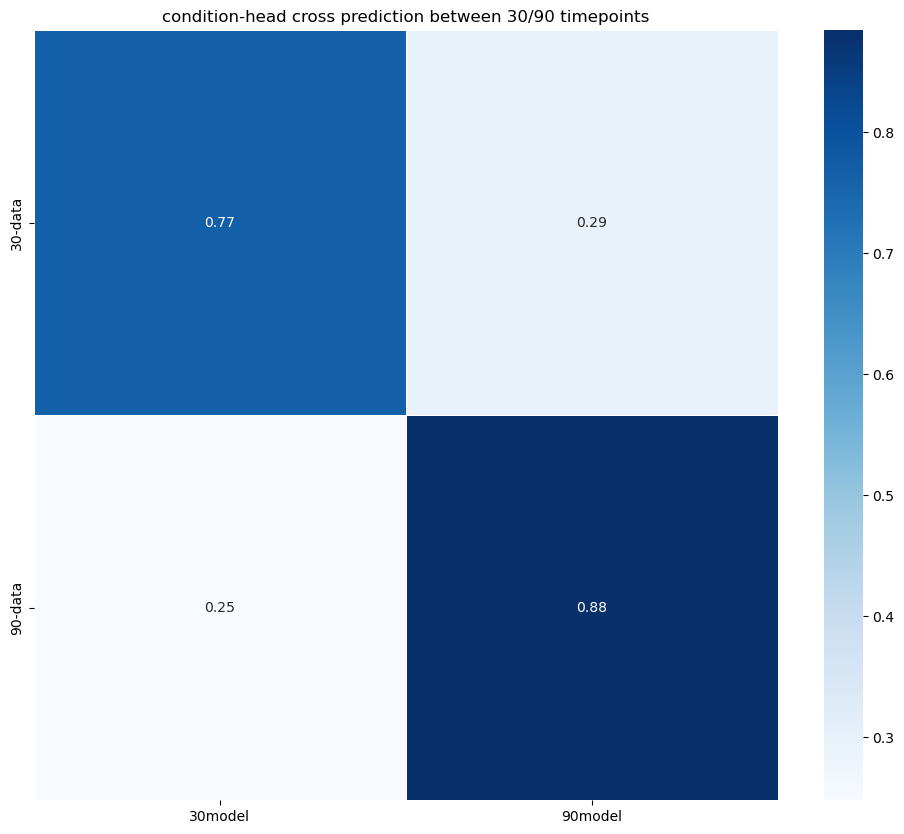

          30model   90model
30-data  0.766788  0.293557
90-data  0.248093  0.884015


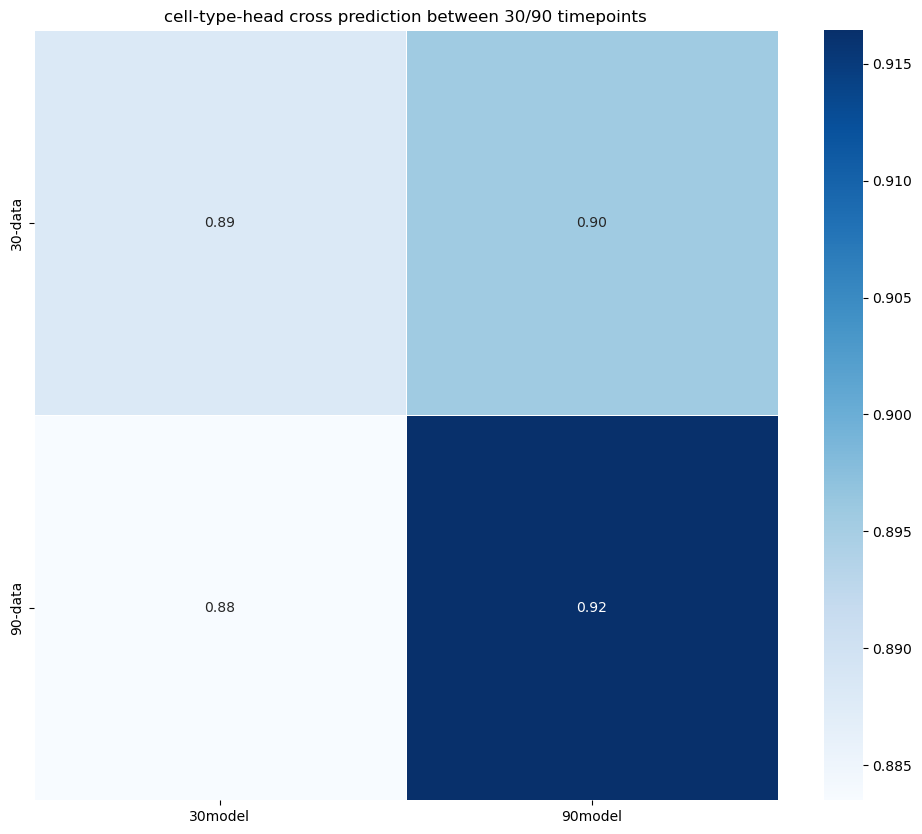

NameError: name 'cross_predict90' is not defined

<Figure size 1200x1000 with 0 Axes>

In [6]:
cp_cond = pd.DataFrame(index = ["30-data", "90-data"])
cp_ct = pd.DataFrame(index = ["30-data", "90-data"])

for i in models:
    cond_res = []
    ct_res = []
    print(models[i].metrics_names)
    metric_names = [
        'loss',
        'condition-out_loss',
        'cell-type-out_loss',
        'cell-type-out_accuracy',
        'condition-out_accuracy'
    ]
    for j in models:
        results = models[i].evaluate(data[j][2][0].X.toarray(), data[j][3])
        results_dict = dict(zip(metric_names, results))

        cond_res.append(results_dict['condition-out_accuracy'])
        ct_res.append(results_dict['cell-type-out_accuracy'])
        
       


    cp_cond[i+"model"] = cond_res
    cp_ct[i+"model"] = ct_res

print(cp_cond)

plt.figure(figsize=(12, 10))
sns.heatmap(cp_cond, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

plt.title("condition-head cross prediction between 30/90 timepoints")
plt.show()

print(cp_cond)

plt.figure(figsize=(12, 10))
sns.heatmap(cp_ct, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

plt.title("cell-type-head cross prediction between 30/90 timepoints")
plt.show()



# cross_predict30 = pd.DataFrame(index = ["30"+x for x in mods])
# time_mods = ["30"+x for x in mods] + ["90" + x for x in mods]
# for i in ["30"+x for x in mods]:
#     results = []
#     for j in ["30"+x for x in mods]:
#         # print(models[time+i])
#         # print(data[time+j])
#         results.append(np.mean(np.argmax(models[i](data[j][2].X), axis = 1) == data[j][3]))

#     cross_predict30[i] = results
# cross_predict30.index.name = "Model"
# cross_predict30.columns.name = "Sample"

# plt.figure(figsize=(12, 10))
# sns.heatmap(cross_predict30, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

# plt.title("30min model cell-type models cross prediction")
# plt.show()

# # print(cross_predict)
# print(time_mods)


# cross_predict90 = pd.DataFrame(index = ["90" + x for x in mods])
# for i in ["90"+x for x in mods]:
#     results = []
#     for j in ["90"+x for x in mods]:
#         # print(models[time+i])
#         # print(data[time+j])
#         results.append(np.mean(np.argmax(models[i](data[j][2].X), axis = 1) == data[j][3]))

#     cross_predict90[i] = results
# cross_predict90.index.name = "Model"
# cross_predict90.columns.name = "Sample"

plt.figure(figsize=(12, 10))
sns.heatmap(cross_predict90, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)

plt.title("90min cell-type models cross prediction")
plt.show()

# print(cross_predict)
print(time_mods)

In [6]:
graph = {x: len(data[x][0]) for x in time_mods}

# Create the bar graph
plt.figure(figsize=(10, 5))  # Adjust figure size
bars = plt.bar(graph.keys(), graph.values(), color='skyblue')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=10)

# Labeling
plt.xlabel("Models")
plt.ylabel("Number of Training Data Sampes")
plt.title("Number of Training Data Samples Per Model")
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show the graph
plt.show()

graph = {x: len(data[x][2]) for x in time_mods}

# Create the bar graph
plt.figure(figsize=(10, 5))  # Adjust figure size
bars = plt.bar(graph.keys(), graph.values(), color='skyblue')

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=10)

# Labeling
plt.xlabel("Models")
plt.ylabel("Number of Training Data Sampes")
plt.title("Number of Training Data Samples Per Model")
plt.xticks(rotation=45)  # Rotate x labels for readability

# Show the graph
plt.show()

NameError: name 'time_mods' is not defined

In [26]:
# calculating the correlation between accuracy and size of training set
sizes = [len(data[x][0]) for x in time_mods]
accuracies = [np.mean(np.argmax(models[i](data[i][2].X), axis = 1) == data[i][3]) for i in time_mods]

print(sizes)
print(accuracies)


correlation = np.corrcoef(sizes, accuracies)[0, 1]
print(f"Overall Pearson Correlation: {correlation}")



[893, 1136, 888, 1239, 3417, 13735, 2473, 1812, 850, 886, 1117, 980, 1356, 2919, 11361, 2143, 1649, 655]
[0.5446428571428571, 0.5633802816901409, 0.5855855855855856, 0.5967741935483871, 0.6654970760233918, 0.7757716948165405, 0.7221324717285945, 0.6233480176211453, 0.4835680751173709, 0.7117117117117117, 0.7142857142857143, 0.6829268292682927, 0.7109144542772862, 0.763013698630137, 0.8708201337557199, 0.8190298507462687, 0.8329297820823245, 0.5975609756097561]
Overall Pearson Correlation: 0.5384227949919305


# Confusion Matrices:

### Aggregate Confusion matrix

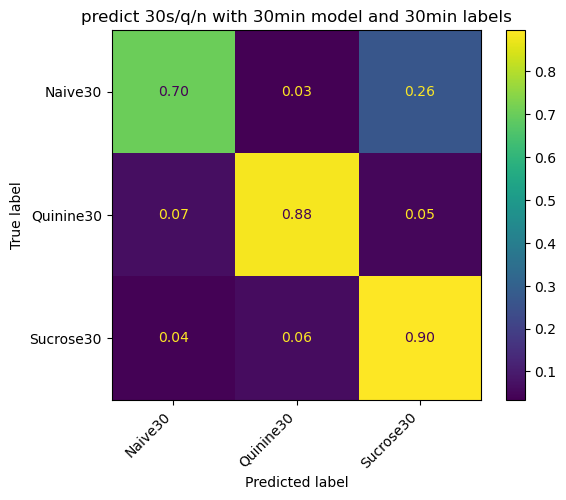

0.3559946416610851
0.3256307211431123
0.3183746371958026


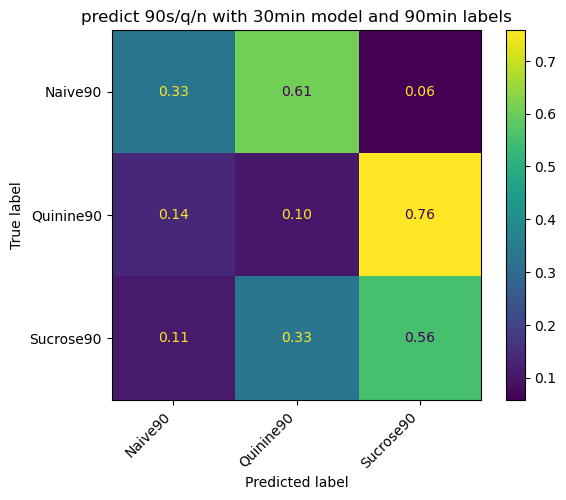

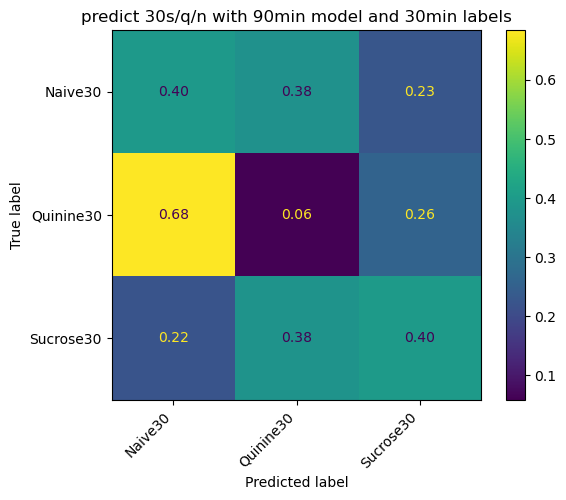

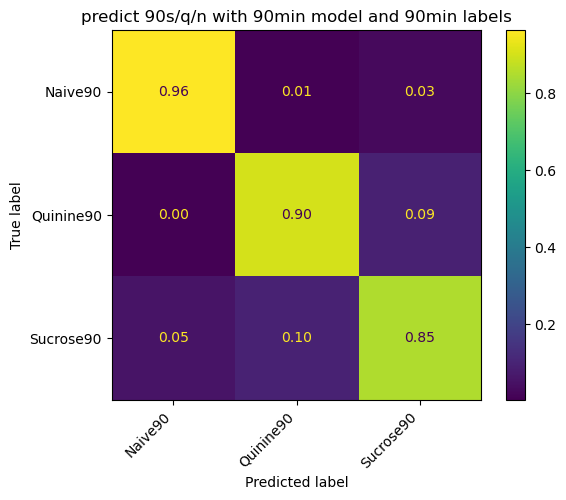

In [33]:

pred30_30 = np.argmax(tf.nn.softmax(model30(m30_test.raw.X.toarray())), axis = 1) 
pred30_90 = np.argmax(tf.nn.softmax(model30(m90_test.raw.X.toarray())), axis = 1) 
label30 = labels = [
'Naive30',
'Quinine30',
'Sucrose30',
]
pred90_30 = np.argmax(tf.nn.softmax(model90(m30_test.raw.X.toarray())), axis = 1)
pred90_90 = np.argmax(tf.nn.softmax(model90(m90_test.raw.X.toarray())), axis = 1) 
label90 = labels = [
'Naive90',
'Quinine90',
'Sucrose90',
]

m30_obs_test
m90_obs_test

def produce_confusion_mat(ground_truth, preds,labels, title):
    confuse_mat = confusion_matrix(ground_truth, preds, normalize = 'true', labels = range(len(labels)))
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=labels)
    
    mat.plot(values_format=".2f")
    
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.show()
    
produce_confusion_mat( m30_obs_test, pred30_30, label30, "predict 30s/q/n with 30min model and 30min labels")

print(np.sum(m30_obs_test == 0)/len(m30_obs_test))
print(np.sum(m30_obs_test == 1)/len(m30_obs_test))
print(np.sum(m30_obs_test == 2)/len(m30_obs_test))


produce_confusion_mat( m90_obs_test, pred30_90, label90, "predict 90s/q/n with 30min model and 90min labels")
produce_confusion_mat( m30_obs_test, pred90_30, label30, "predict 30s/q/n with 90min model and 30min labels")
produce_confusion_mat( m90_obs_test, pred90_90, label90, "predict 90s/q/n with 90min model and 90min labels")


# print(np.sum(pred30_30 == 1)/len(pred30_30) * np.sum((m30_obs_test == 1) == (pred30_30 == 2)))
# print(np.sum((m30_obs_test == 2) == (pred30_30 == 2)))
# print((m30_obs_test == 2) == (pred30_30 == 2))
# print(np.sum(m30_obs_test == 2))
# print(np.sum(pred30_30 == 2)/len(pred30_30) * np.sum((m30_obs_test == 2) == (pred30_30 == 2))/np.sum(m30_obs_test == 2))

# Original Condition  Encoded Condition
# AAACCCAAGACCTGGA-1-0-adlib30              adlib30                  0  bored 2 = 0
# AAACCCAAGAGAGTGA-1-0-adlib90              adlib90                  1  naive 30 3 = 1
# AAACCCAAGCCTTTGA-1-0-bored                  bored                  2  naive 90 4 = 2
# AAACCCAAGACGCCCT-1-0-naive30              naive30                  3  adlib30 0 = 3
# AAACCCAAGAGGTTTA-1-0-naive90              naive90                  4  adlib90 1 = 4
# AAACCCAAGTTCACTG-1-0-quinine30          quinine30                  5  sucrose30 7 = 5
# AAACCCAAGGAGCAAA-1-0-quinine90          quinine90                  6  sucrose 90 8 = 6
# AAACCCAAGACGCCCT-1-0-sucrose30          sucrose30                  7  quinine30 5 = 7
# AAACCCAAGAGGTCAC-1-0-sucrose90          sucrose90                  8  quinine90 6 = 8

# AAACCCAAGACCTGGA-1-0-adlib30              adlib30                  0 
# AAACCCAAGAGAGTGA-1-0-adlib90              adlib90                  1
# AAACCCAAGCCTTTGA-1-0-bored                  bored                  2
# AAACCCAAGACGCCCT-1-0-naive30              naive30                  3
# AAACCCAAGAGGTTTA-1-0-naive90              naive90                  4
# AAACCCAAGTTCACTG-1-0-quinine30          quinine30                  5
# AAACCCAAGGAGCAAA-1-0-quinine90          quinine90                  6
# AAACCCAAGACGCCCT-1-0-sucrose30          sucrose30                  7
# AAACCCAAGAGGTCAC-1-0-sucrose90          sucrose90                  8

labels = [
'Bored',
'Naive30',
'Naive90',
'Adlib30',
'Adlib90',
'Sucrose30',
'Sucrose90',
'Quinine30',
'Quinine90']

order_conversion = {
    2: 0, 
    3: 1, 
    4: 2,
    0: 3, 
    1: 4, 
    7: 5, 
    8: 6, 
    5: 7, 
    6: 8, 
}


# print(np.mean(np.argmax(model.predict(X_test.raw.X.toarray()), axis=1) == obs_test.tolist()))
# ground_truth = obs_test.tolist()
# # print(ground_truth)

# for i in range(len(ground_truth)):
#     ground_truth[i] = order_conversion[ground_truth[i]]

# preds = np.argmax(tf.nn.softmax(model.predict(X_test.raw.X.toarray())), axis = 1)

# # model.evaluate(X_test.raw.X.toarray(), ground_truth)
# for i in range(len(preds)):
#     preds[i] = order_conversion[preds[i]]
# print(np.mean(preds == ground_truth))


# print(obs_test.shape)
# .35
# .2259

[0.00524934 0.01946678 0.01411879 0.01061853 0.11896552 0.00801603
 0.02913907 0.02566248 0.04871712]


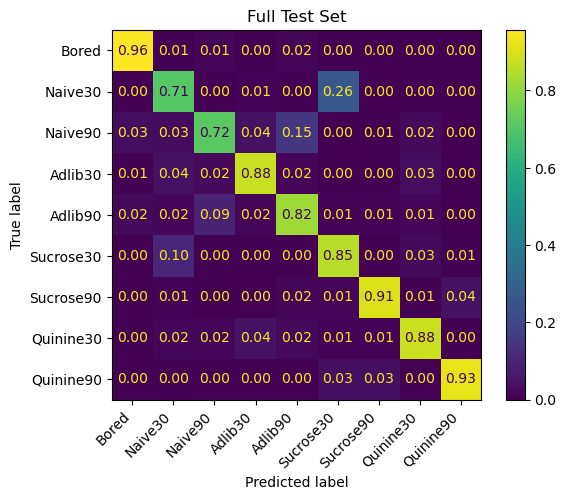

In [20]:
confuse_mat = confusion_matrix(ground_truth, preds, normalize = 'true', labels = range(len(labels)))
print(f1_score(obs_test, preds, average=None))
mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=labels)

mat.plot(values_format=".2f")

plt.xticks(rotation=45, ha='right')
plt.title("Full Test Set")
plt.show()

### Individual Confusion matrices for each cell type, using Leiden clustering


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


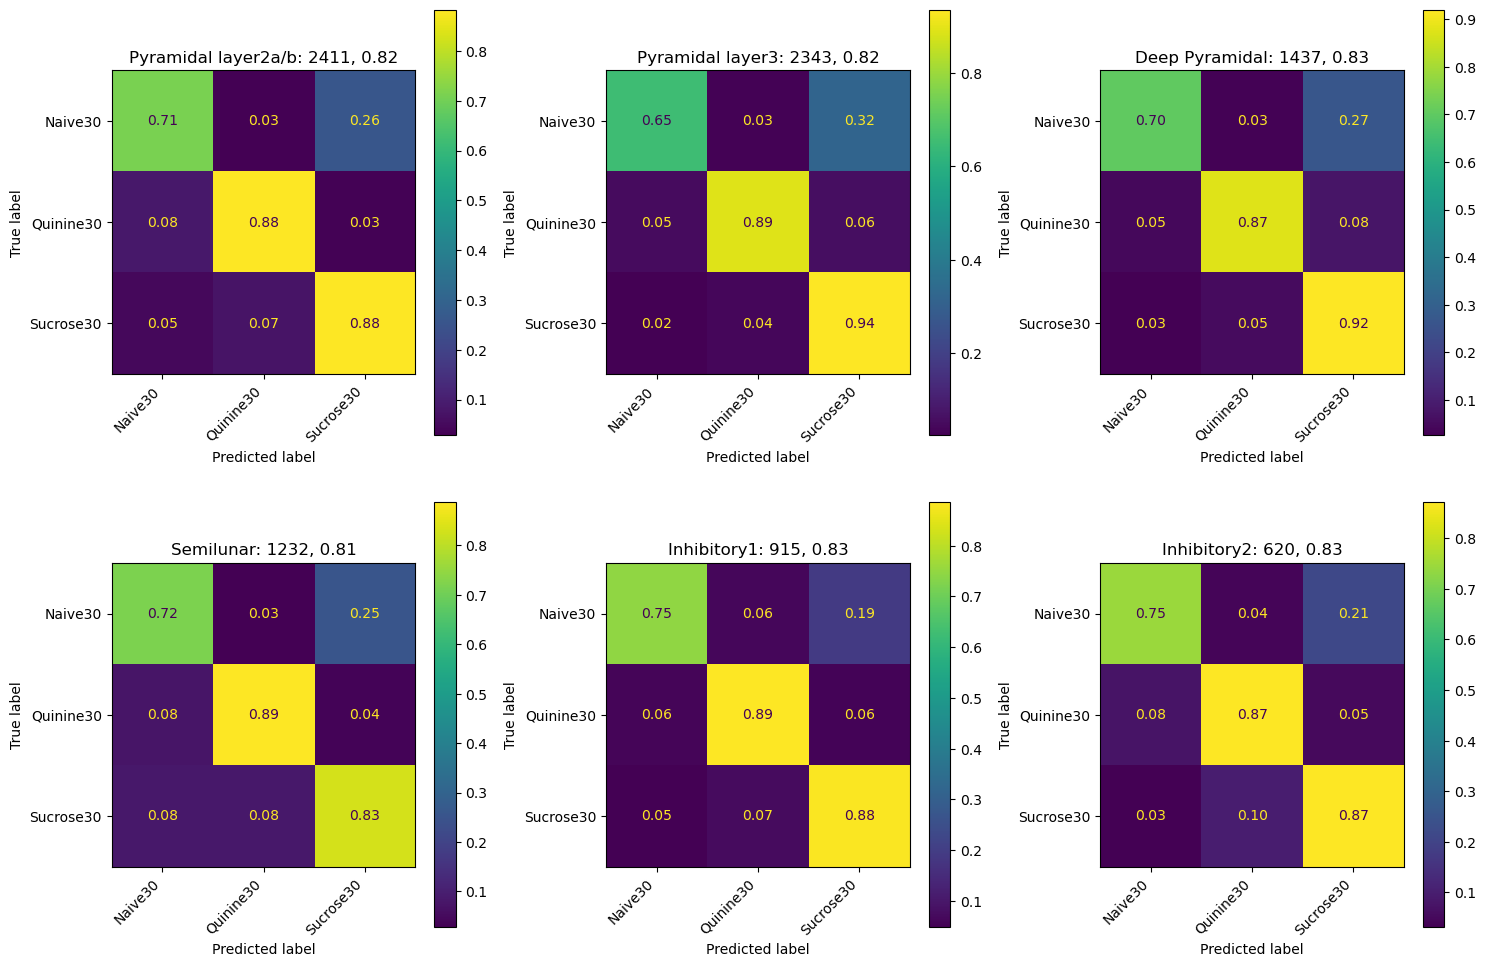

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


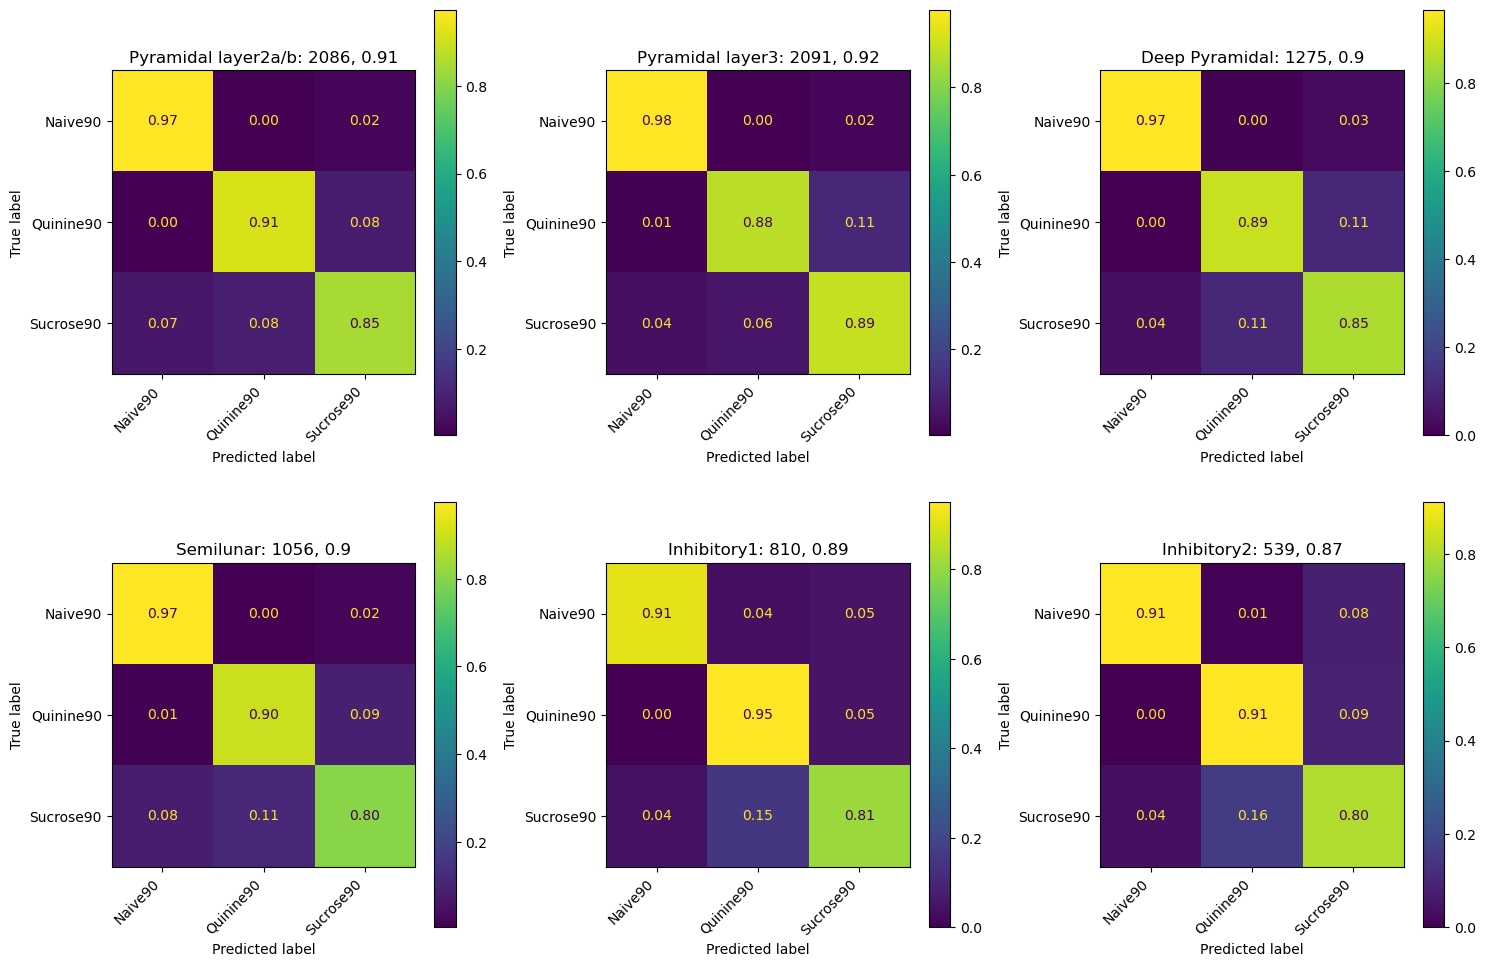

In [48]:
# print(m30_train.obs['leiden'])
# print(m30_test.obs['condition'])
# print(m30_test.obs['encoded_condition'])

# Loop through each condition

data = pd.DataFrame()
# Create a figure with subplots

# 30 min model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust grid based on the number of clusters
axes = axes.flatten()  # Flatten for easier iteration
for i in range(6):
    cluster_samples = m30_test[m30_test.obs['leiden'] == str(i)]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']

    # Forward pass
    preds = np.argmax(tf.nn.softmax(model30.predict(X)), axis=1)
    accuracy = np.mean(preds == Y)

    # Compute confusion matrix
    confuse_mat = confusion_matrix(Y, preds, normalize='true')

    # Plot confusion matrix in subplot
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=label30)
    mat.plot(ax=axes[i], values_format=".2f")

    axes[i].set_xticklabels(label30, rotation=45, ha='right')
    axes[i].set_title(f"{cluster_decode[i]}: {len(cluster_samples)}, {round(accuracy, 2)}")

# Adjust layout and save the figure
plt.tight_layout()
plt.show()
    

# 90 min model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust grid based on the number of clusters
axes = axes.flatten()  # Flatten for easier iteration
for i in range(6):
    cluster_samples = m90_test[m90_test.obs['leiden'] == str(i)]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']

    # Forward pass
    preds = np.argmax(tf.nn.softmax(model90.predict(X)), axis=1)
    accuracy = np.mean(preds == Y)

    # Compute confusion matrix
    confuse_mat = confusion_matrix(Y, preds, normalize='true')

    # Plot confusion matrix in subplot
    mat = ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=label90)
    mat.plot(ax=axes[i], values_format=".2f")

    axes[i].set_xticklabels(label90, rotation=45, ha='right')
    axes[i].set_title(f"{cluster_decode[i]}: {len(cluster_samples)}, {round(accuracy, 2)}")
    # 0 = naive, 1 = quinine, 2 = sucrose
    
plt.tight_layout()
plt.show()


### Individual Confusion Matrices for each condition

In [14]:
m30_test.obs['condition'].unique()
# start from m30
for i in X_test.obs['condition'].unique():
    print(f"Leiden cluster: {i}")
    cluster_samples = X_test[X_test.obs['leiden'] == i]
    X = cluster_samples.raw.X.toarray()
    Y = cluster_samples.obs['encoded_condition']
    
    # forward pass
    # X = np.expand_dims(X, axis = 2)
    preds = np.argmax(tf.nn.softmax(model.predict(X)), axis = 1)

    

NameError: name 'X_test' is not defined

# Section 1: 
Single-sample SHAP interpretation

In [6]:
with open('full_test_set_shap.pkl', 'rb') as f:
    full_test_shap = pickle.load( f)

FileNotFoundError: [Errno 2] No such file or directory: 'full_test_set_shap.pkl'

In [ ]:
# printing the shap values and thier shape

copy_shap_vals = np.array(full_test_shap)
copy_shap_vals = np.squeeze(copy_shap_vals)
print(copy_shap_vals.shape)

# aggregating the shap values into a averages.
print(avg_shap_vals.shape)

# producing explanations for the shap values. 
explanation = shap.Explanation(copy_shap_vals)

shap_vals_sample = copy_shap_vals[0, :, :]  # Selecting SHAP values for the first sample
print(shap_vals_sample.shape)

# Single sample interpretation
for class_idx in range(shap_vals_sample.shape[1]):
    explained = shap.Explanation(values=shap_vals_sample[:, class_idx],
                                 feature_names= feature_names)
    shap.plots.bar(explained)
    print(class_idx)


# shap.plots.bar(avg_explanation)



# Section 2
We attempt to aggregate the cells to perform aggregate shap analyses.

In [5]:
# Loading in the data:

def get_shap(time):
    with open(f'../pickles/{time}min-data/aggregate_shap.pkl', 'rb') as f:
        shap_vals = pickle.load(f)
    with open(f'../pickles/{time}min-data/aggregate_shap_samples.pkl', 'rb') as f:
        shap_samples = pickle.load(f)

    return shap_vals, shap_samples
    

AnnData object with n_obs × n_vars = 300 × 3000
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2', 'encoded_condition', 'encoded_ct'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'
(896, 3000, 3)
(3, 3000)
[0.01154547 0.00566136 0.00834415 ... 0.05494196 0.02469465 0.05325067]


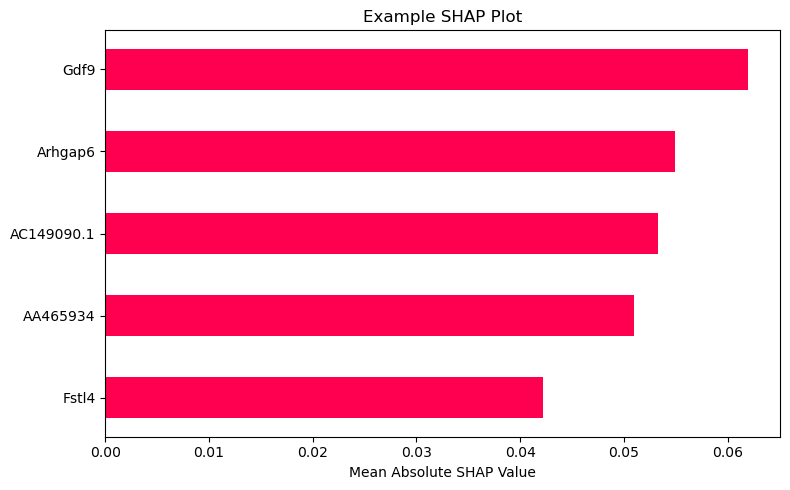

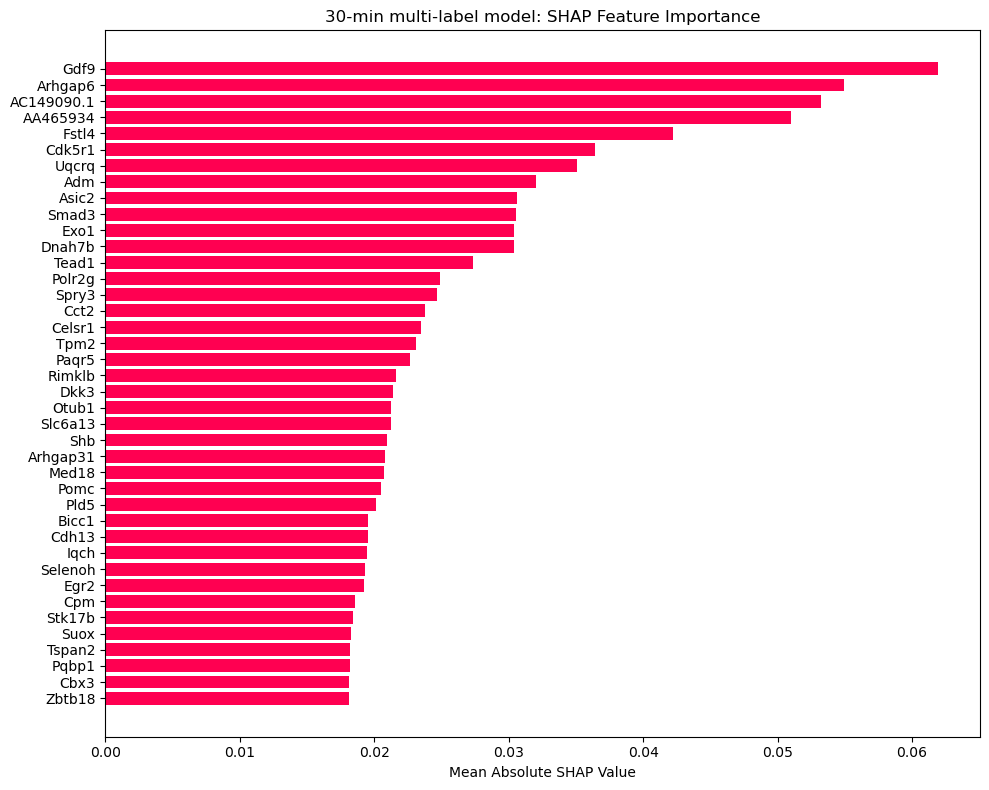

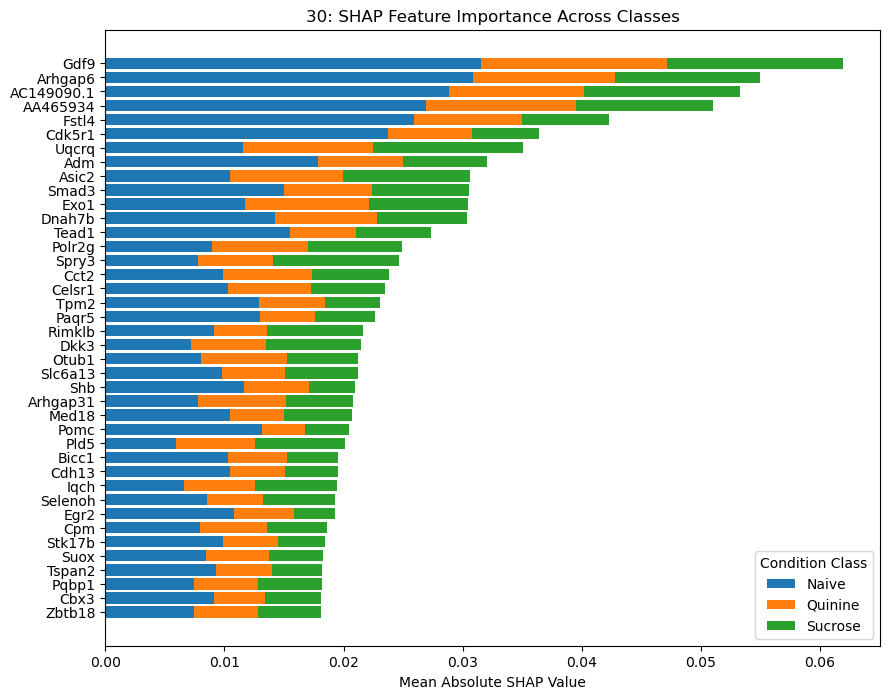

AnnData object with n_obs × n_vars = 300 × 3000
    obs: 'frac_mito', 'n_counts', 'n_genes', 'replicate', 'condition', 'doublet_score', 'predicted_doublet', 'leiden_res_1.75', 'cell_type_lvl_2', 'encoded_condition', 'encoded_ct'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_lvl_2_colors', 'condition_colors', 'dendrogram_cell_type_lvl_2', 'hvg', 'leiden_res_1.75', 'leiden_res_1.75_colors', 'neighbors', 'neighbors_harmony', 'pca', 'replicate_colors', 'umap', 'umap_noharmony'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_noharmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_harmony_connectivities', 'neighbors_harmony_distances'
(786, 3000, 3)
(3, 3000)
[0.05324786 0.01550006 0.06165939 ... 0.15483132 0.11068936 0.25070859]


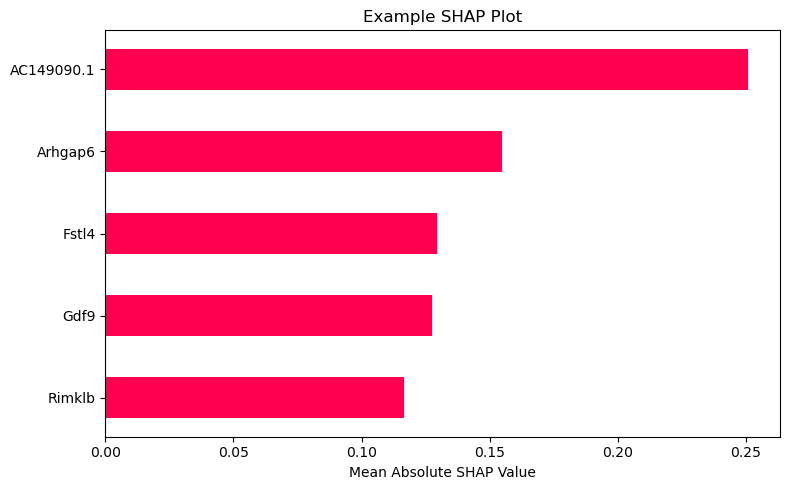

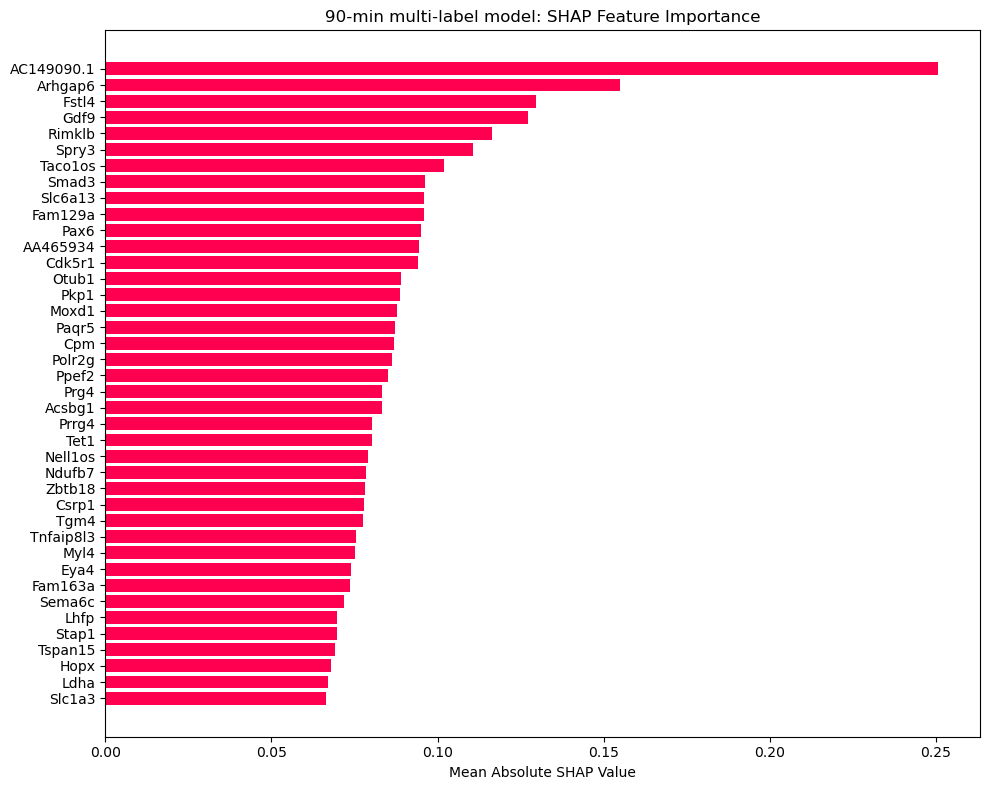

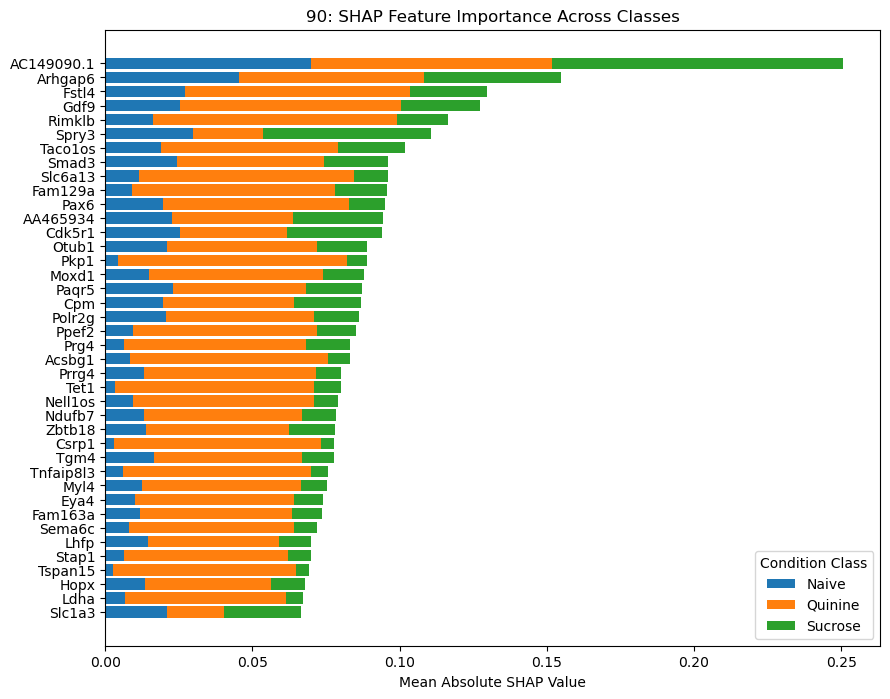

In [6]:

def generate_shap(model, shap_vals, shap_samples, which_model):
    feature_names = shap_vals.var.index.tolist()
    # shap.summary_plot(
    #     shap_vals.mean(1),  # Aggregate over samples per class
    #     features=feature_names, 
    #     max_display=20, 
        
    #     plot_type="bar"
    # )    # Set title
    # Reshape SHAP values if necessary
    shap_vals = np.array(shap_vals).reshape((3, len(shap_samples), hp.num_features))

    # Create a figure with 1 row and 3 columns (for each class)

    # Plot SHAP values for each class in a separate subplot by redirecting the output to a specific subplot
    shap.summary_plot(shap_vals[0], features=feature_names, max_display=20, plot_type="bar",)

    shap.summary_plot(shap_vals[1], features=feature_names, max_display=20, plot_type="bar", )


    shap.summary_plot(shap_vals[2], features=feature_names, max_display=20, plot_type="bar", )

    # Adjust layout and display the plots

def generate_shap_stacked_bar(model, shap_vals, shap_samples, which_model):
    print(shap_samples)
    print(shap_vals.shape)
    

    feature_names = shap_samples.var.index.tolist()
    shap_vals = np.array(shap_vals).reshape((3, len(shap_vals), 3000))
    mean_shap_vals = np.abs(shap_vals).mean(axis=1)  # collapse the second dimension and aggeregate all the cell samples into 1: 
    # Shape: (3, num_features)

    
    print(mean_shap_vals.shape)
    total_shap = mean_shap_vals.sum(axis=0)
    print(total_shap)
    
    # Top 5 features, no class separation
    sorted_indices = np.argsort(total_shap)[::-1][:5]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_shap_vals = total_shap[sorted_indices]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))

    y_positions = np.arange(len(sorted_features))
    bar_color = "#FF0051"  # SHAP-like red

    bar_height = 0.5  # Make bars slimmer (default is ~0.8)

    ax.barh(y_positions, sorted_shap_vals, color=bar_color, height=bar_height)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(sorted_features, fontsize=10)
    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_title(f"Example SHAP Plot")
    ax.invert_yaxis()  # Highest feature at top
    plt.tight_layout()
    plt.show()

    # top 40, no class separation 
    sorted_indices = np.argsort(total_shap)[::-1][:40]
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_shap_vals = total_shap[sorted_indices]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    y_positions = np.arange(len(sorted_features))
    bar_color = "#FF0051"  # SHAP-like red

    ax.barh(sorted_features, sorted_shap_vals, color=bar_color,  )

    ax.set_yticks(y_positions)
    ax.set_yticklabels(sorted_features, fontsize=10)
    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_title(f"{which_model}-min multi-label model: SHAP Feature Importance")
    ax.invert_yaxis()  # Highest feature at top
    plt.tight_layout()
    plt.show()
    
    
    # top 40, with class separation 
    sorted_indices = np.argsort(total_shap)[::-1][:40]  # Top 20 features
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_shap_vals = mean_shap_vals[:, sorted_indices]  # Keep top features
    # class colors
    class_labels = ["Naive",  "Quinine", "Sucrose",]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 8))
    bottom = np.zeros(len(sorted_features))  # Initialize bottom stack
    for i, (class_name, color) in enumerate(zip(class_labels, colors)):
        ax.barh(sorted_features, sorted_shap_vals[i], left=bottom, label=class_name, color=color)
        bottom += sorted_shap_vals[i]  # Stack bars

    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_title(f"{which_model}: SHAP Feature Importance Across Classes")
    ax.legend(title="Condition Class")
    plt.gca().invert_yaxis()  # Highest feature at the top
    plt.show()

    return which_model, sorted_features


top_features = pd.DataFrame()
for time in ["30", "90"]:
    shap_vals, shap_samples = get_shap(time)
    mod, feats = generate_shap_stacked_bar(models[time], shap_vals, shap_samples, time)

    top_features[mod] = feats

top_features.to_csv("../csvs/top_features.csv")

In [7]:
len(set(top_features['30'].tolist()).intersection(set(top_features['90'].tolist())))
set(top_features['30'].tolist()).intersection(set(top_features['90'].tolist()))

{'AA465934',
 'AC149090.1',
 'Arhgap6',
 'Cdk5r1',
 'Cpm',
 'Fstl4',
 'Gdf9',
 'Otub1',
 'Paqr5',
 'Polr2g',
 'Rimklb',
 'Slc6a13',
 'Smad3',
 'Spry3',
 'Zbtb18'}

../pickles/30min-data/IN_CGE_NPY_shap.pkl
(3, 3000)


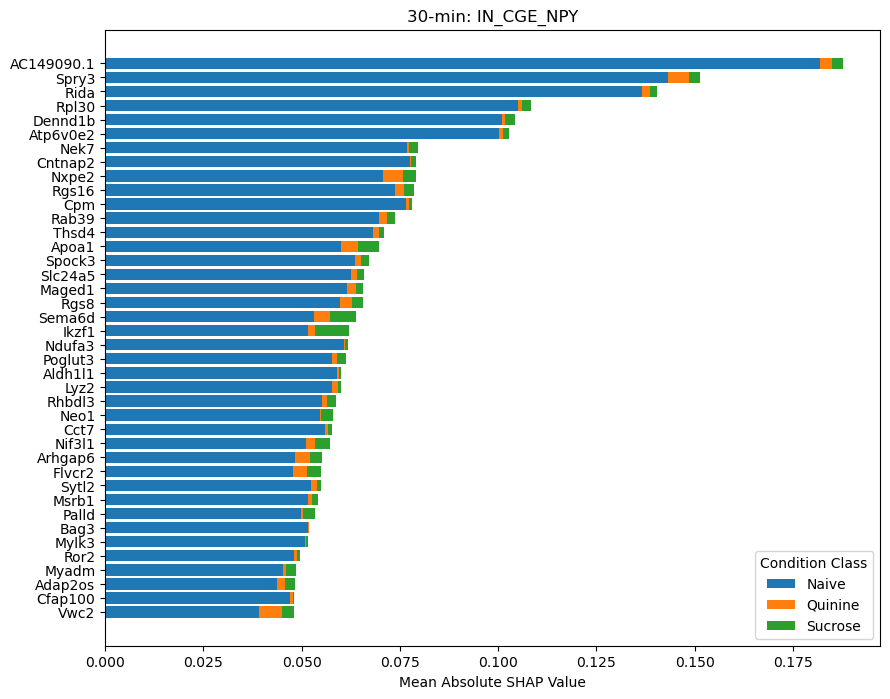

../pickles/30min-data/IN_CGE_VIP_shap.pkl
(3, 3000)


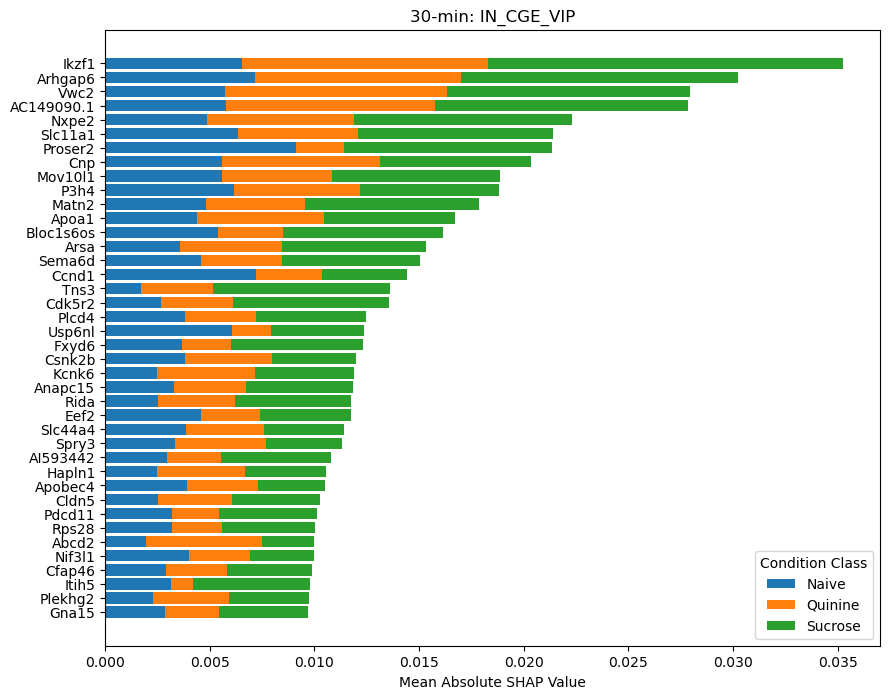

../pickles/30min-data/IN_MGE-Pvalb_shap.pkl
(3, 3000)


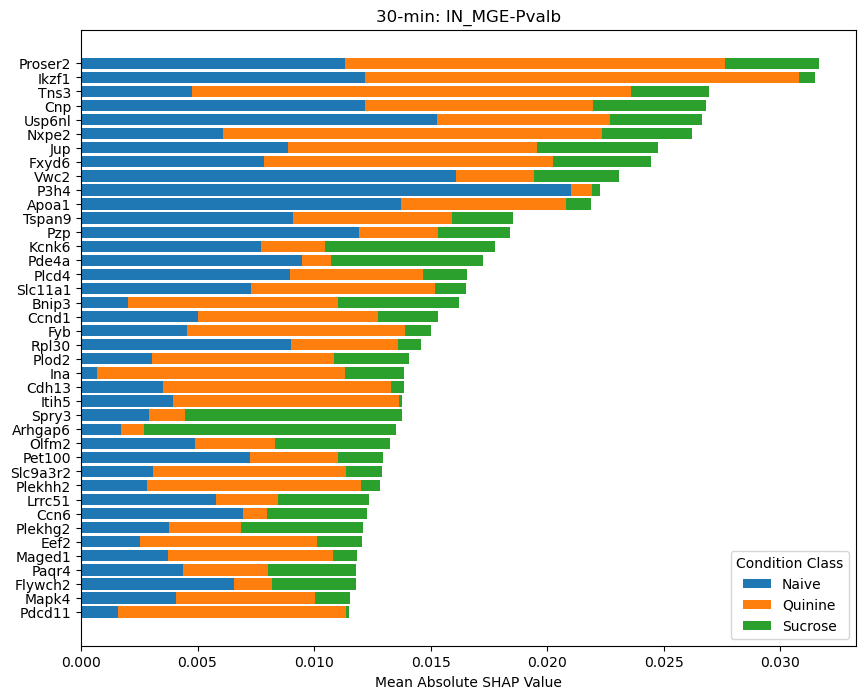

../pickles/30min-data/IN_MGE-SST_shap.pkl
(3, 3000)


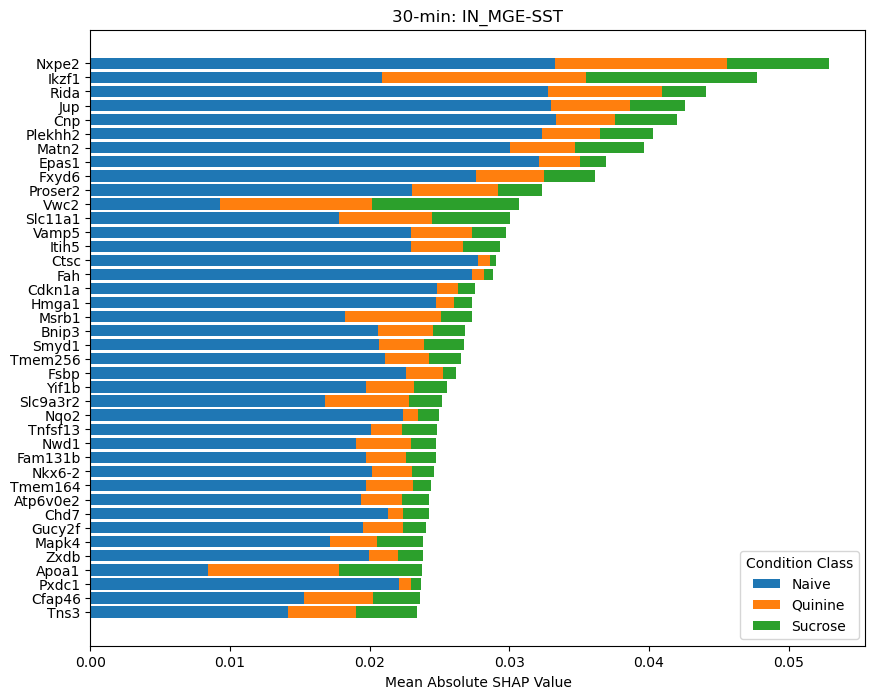

../pickles/30min-data/Pyrlayer2a/b_shap.pkl
(3, 3000)


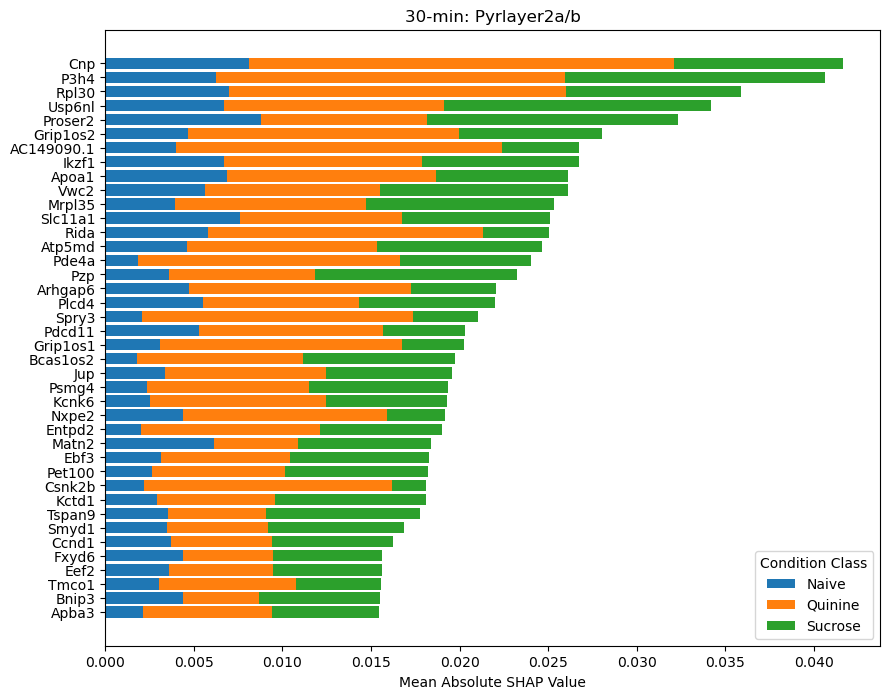

../pickles/30min-data/Pyrlayer3_shap.pkl
(3, 3000)


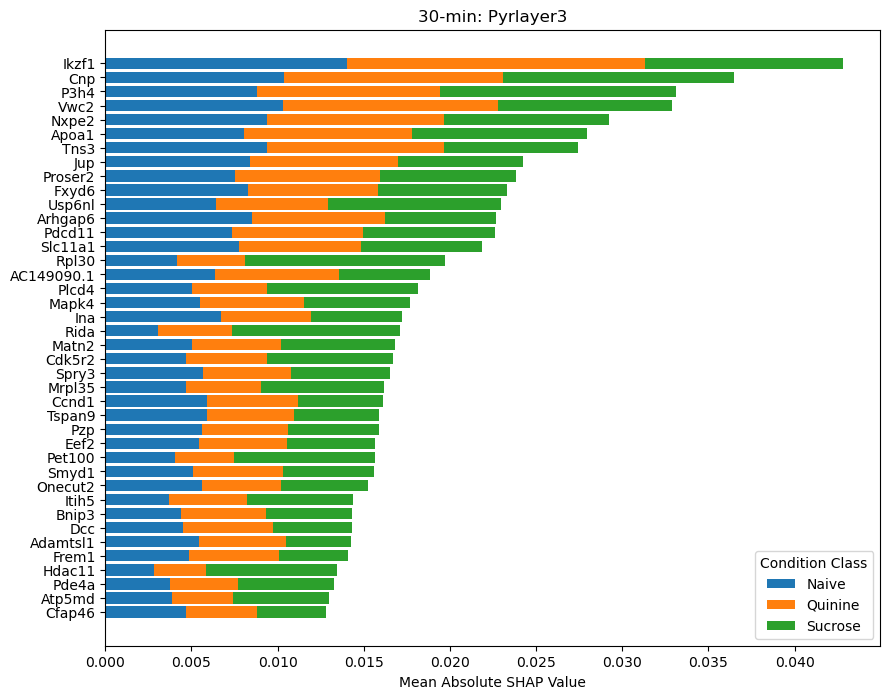

../pickles/30min-data/SL1_shap.pkl
(3, 3000)


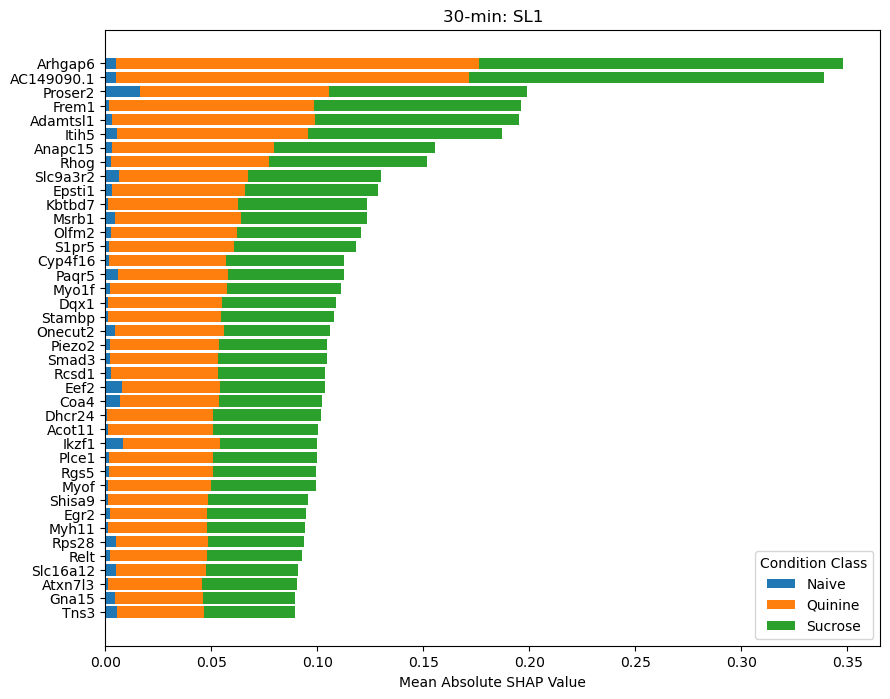

../pickles/30min-data/SL2_shap.pkl
(3, 3000)


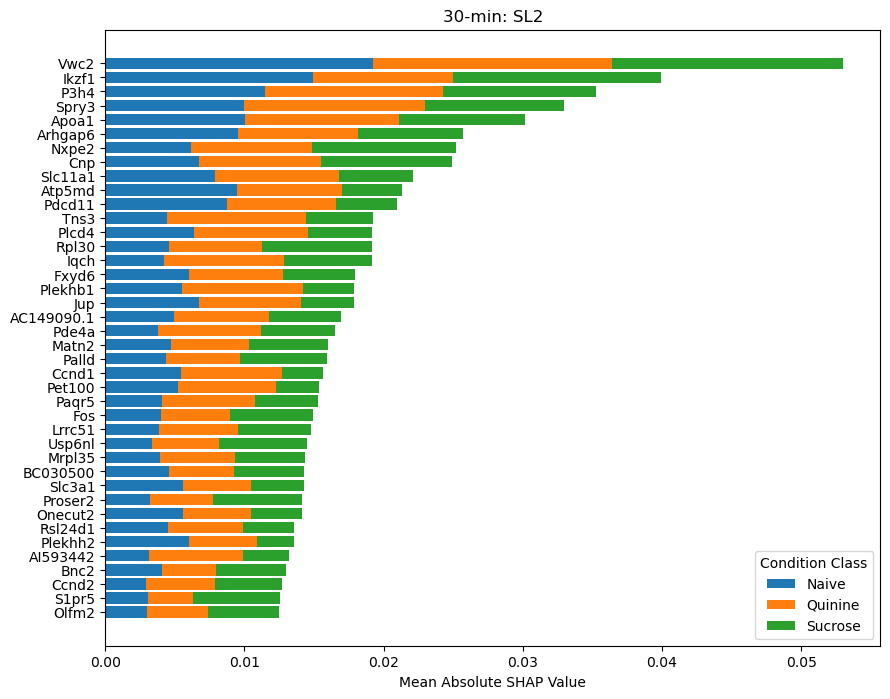

../pickles/30min-data/Vglut2_shap.pkl
(3, 3000)


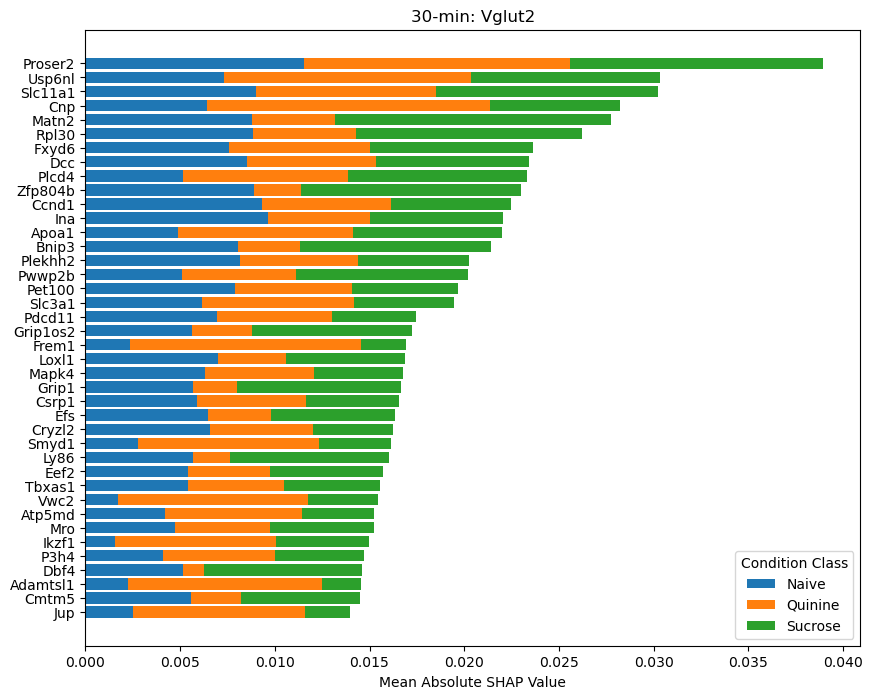

../pickles/90min-data/IN_CGE_NPY_shap.pkl
(3, 3000)


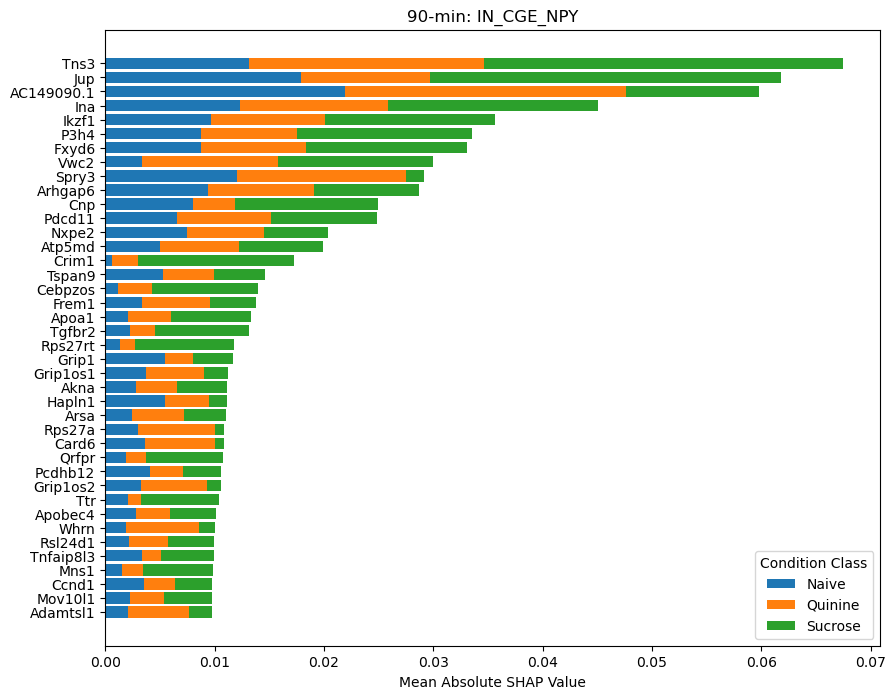

../pickles/90min-data/IN_CGE_VIP_shap.pkl
(3, 3000)


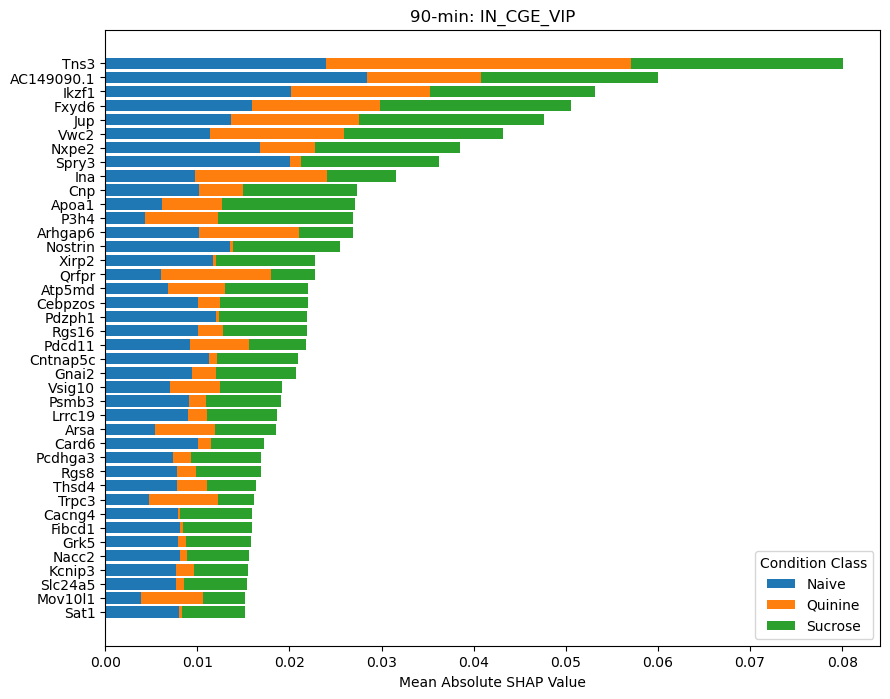

../pickles/90min-data/IN_MGE-Pvalb_shap.pkl
(3, 3000)


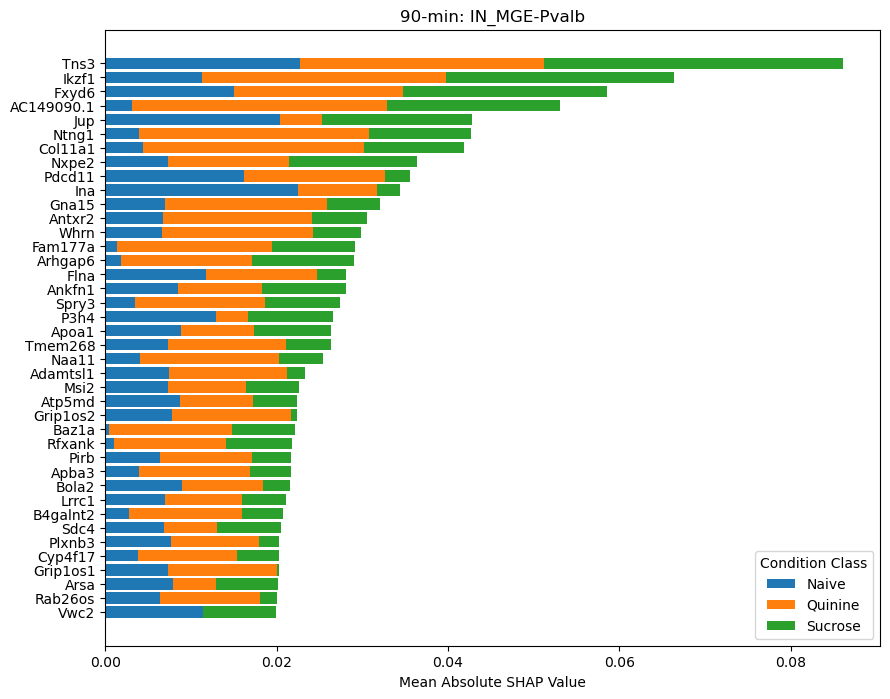

../pickles/90min-data/IN_MGE-SST_shap.pkl
(3, 3000)


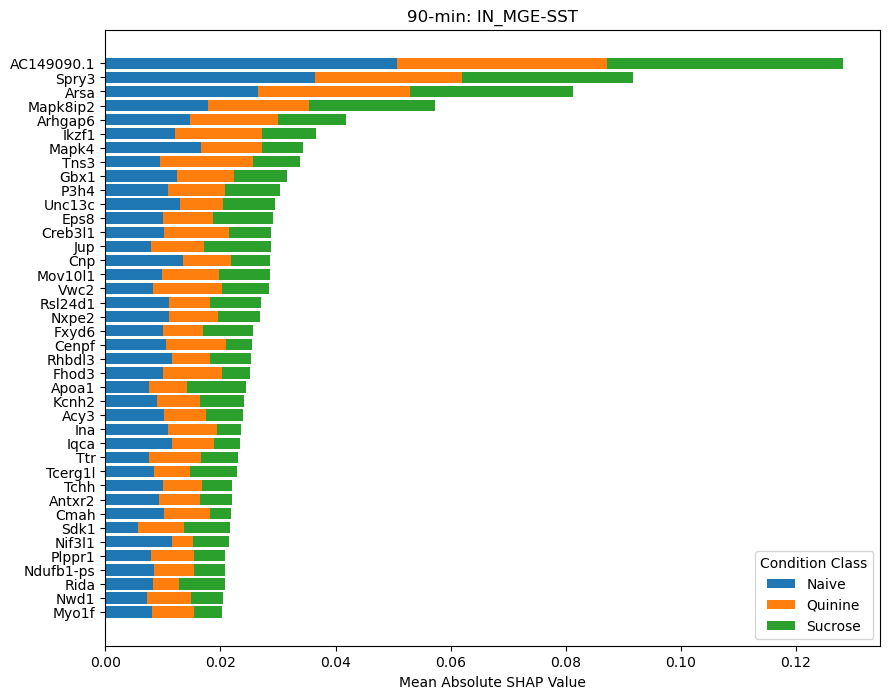

../pickles/90min-data/Pyrlayer2a/b_shap.pkl
(3, 3000)


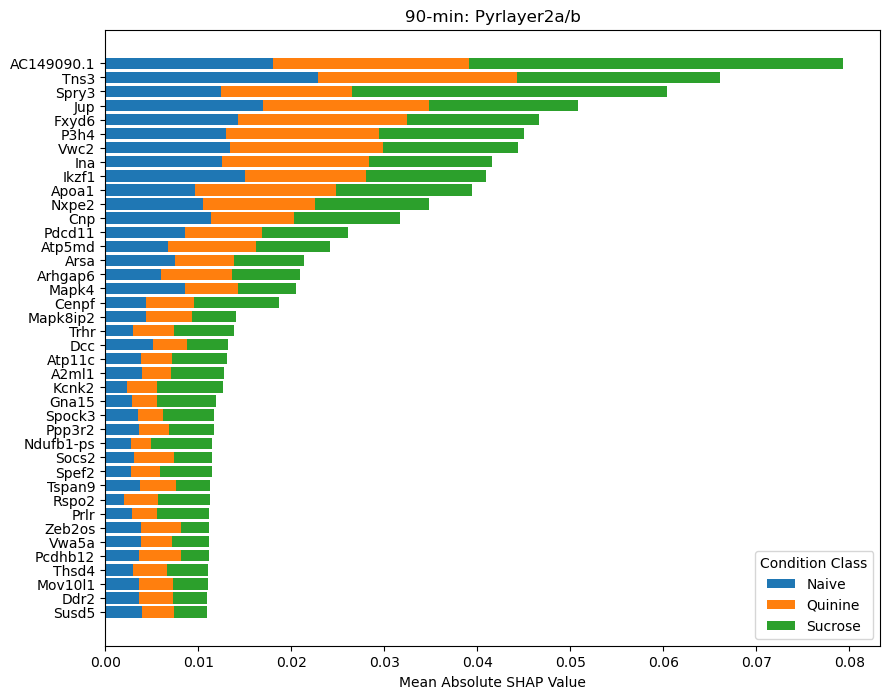

../pickles/90min-data/Pyrlayer3_shap.pkl
(3, 3000)


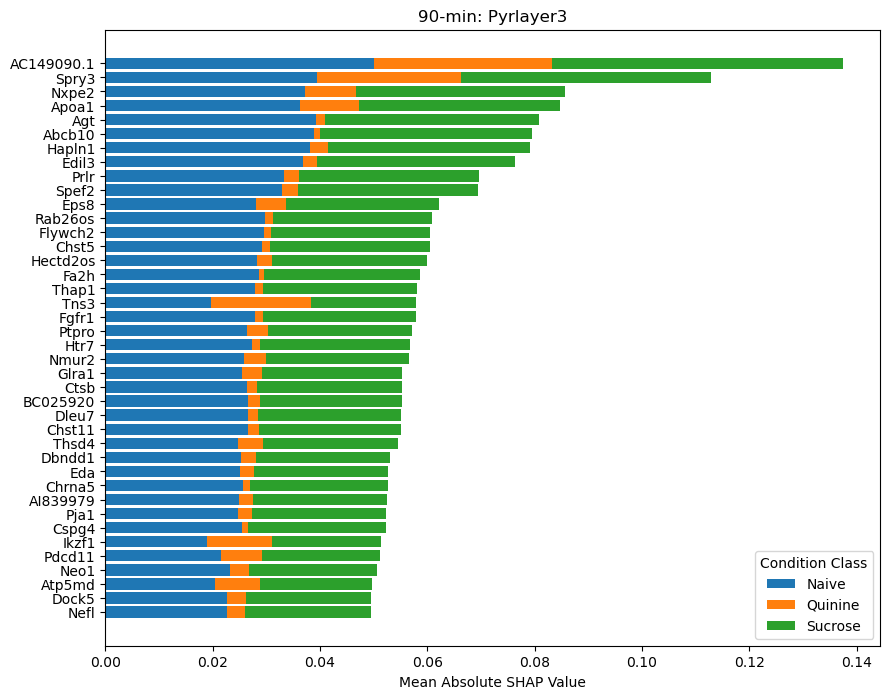

../pickles/90min-data/SL1_shap.pkl
(3, 3000)


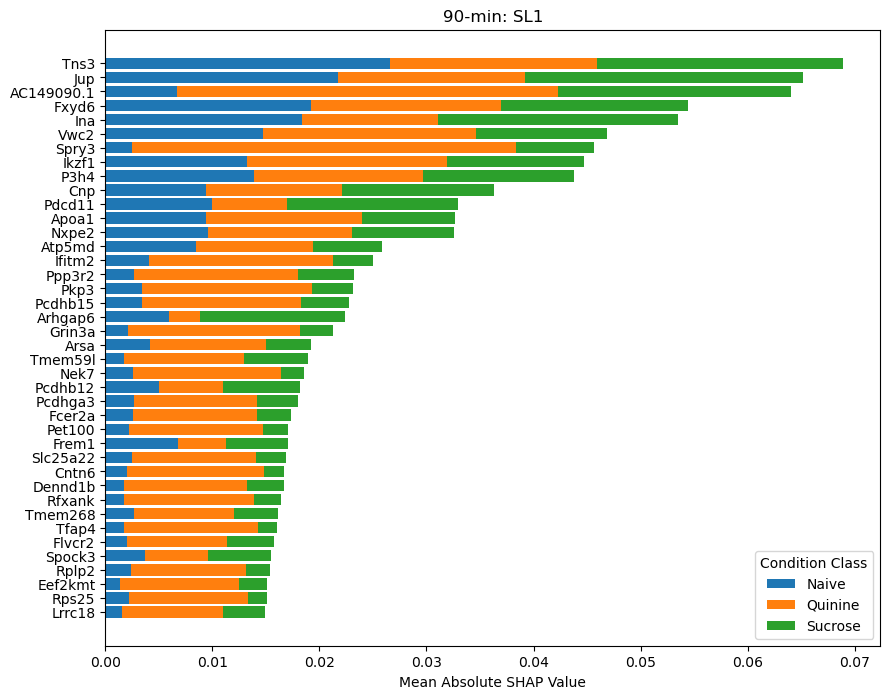

../pickles/90min-data/SL2_shap.pkl
(3, 3000)


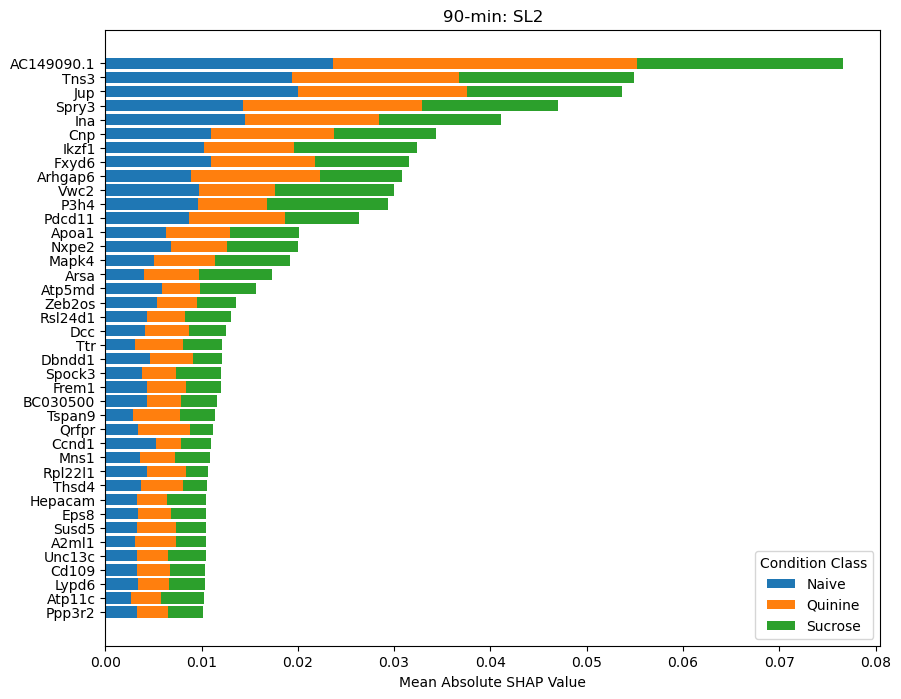

../pickles/90min-data/Vglut2_shap.pkl
(3, 3000)


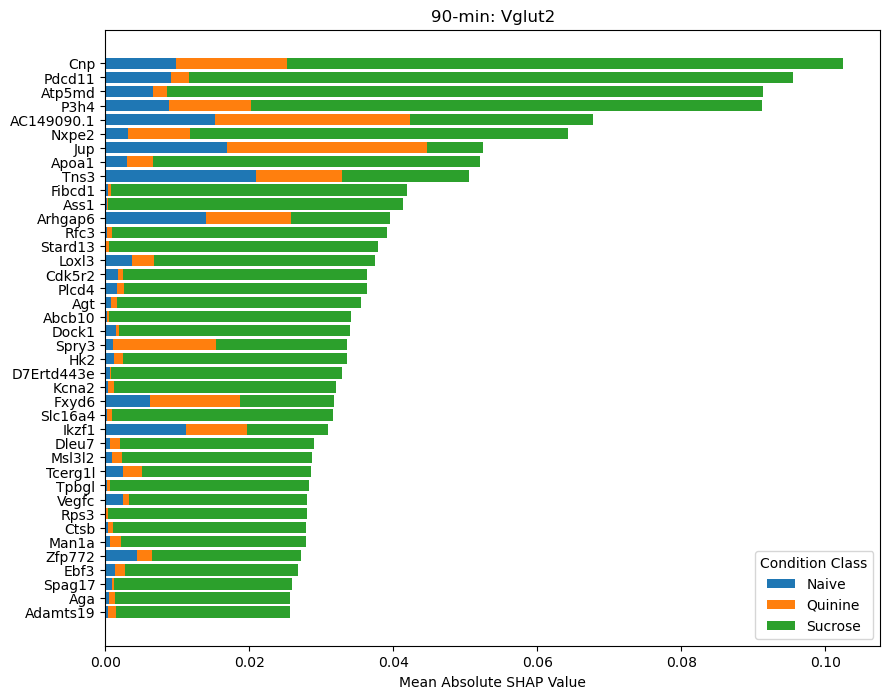

In [17]:
tps = sorted(data['30'][0][0].obs['cell_type_lvl_2'].unique())

overlap = pd.DataFrame()
for t in ["30", "90"]:
    for ty in tps:
        
        with open(f'../pickles/{t}min-data/{ty}_shap.pkl', 'rb') as f:
            shap_vals = pickle.load(f)
        with open(f'../pickles/{t}min-data/{ty}_shap_data_subset.pkl', 'rb') as f:
            shap_samples = pickle.load(f)
        
        print(f'../pickles/{t}min-data/{ty}_shap.pkl')

        feature_names = shap_samples.var.index.tolist()

        # Reshape SHAP values properly
        shap_vals = np.array(shap_vals).reshape((3, len(shap_vals), 3000))
        
        # Compute mean absolute SHAP values per class
        mean_shap_vals = np.abs(shap_vals).mean(axis=1)  # Shape: (3, num_features)
        print(mean_shap_vals.shape)
    
        # Sum across classes to determine total importance
        total_shap = mean_shap_vals.sum(axis=0)
    
        # Sort features by total importance
        sorted_indices = np.argsort(total_shap)[::-1][:40]  # Top 20 features
        sorted_features = [feature_names[i] for i in sorted_indices]
        overlap[t + ty] = sorted_features
        sorted_shap_vals = mean_shap_vals[:, sorted_indices]  # Keep top features
        
        # Define class colors
        class_labels = ["Naive",  "Quinine", "Sucrose",]
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
    
        # Plot stacked bar chart
        fig, ax = plt.subplots(figsize=(10, 8))
        bottom = np.zeros(len(sorted_features))  # Initialize bottom stack
    
        for i, (class_name, color) in enumerate(zip(class_labels, colors)):
            ax.barh(sorted_features, sorted_shap_vals[i], left=bottom, label=class_name, color=color)
            bottom += sorted_shap_vals[i]  # Stack bars
    
        ax.set_xlabel("Mean Absolute SHAP Value")
        ax.set_title(f"{t}-min: {ty}")
        ax.legend(title="Condition Class")
        plt.gca().invert_yaxis()  # Highest feature at the top
        plt.show()
        
overlap.to_csv("../csvs/overlap.csv")

In [15]:
lrgs = set([
    "Fndc9", "Meox1","Scg2", "Kcnj4","Glt28d2", "Gpr3","Mbnl2", "Trip10","Maml3", "Cd109","Csrnp1", "Gpr63","Sv2c", "Tll1","Hsd17b12", "Bmp3","Crhbp", "Stc1","Col10a1", "Klhl4","Gch1", "Sostdc1","Tac1", "Spred3","Errfi1", "Sowahb","C2cd4b", "Slitrk4","Prok2", "Mfap3l","Slc2a3", "Kcna1","Cartpt", "Fezf2","Kcnj3", "Dennd2c","Chrm2", "Stc2","Mlf1", "Hdac9", "Dusp4", "Hunk","Popdc3", "Pthlh","Ccdc184", "Pnoc","Dusp14", "Kcnh8","Kcnf1", "Acan","Alpk1", "Gper1","Rgs2", "Omg","Wdr90", "Chac1","Grasp", "Stac","Coq10b", "Nptx2","Fam126b", "Kcna4","Mctp2", "Sema3e","Bdnf", "Palmd", "Gem", "Rab39","Tiparp", "Serpinb2","Gpr22", "Hspb3","Pcsk1", "5430416O09Rik","Cystm1", "9430020K01Rik","Ptgs2", "Dmxl1", "Per1", "Cdkn1a", "Ptger4", "Fbxo33", "Adm", "Sik1","Pax1", "Crem","Pou3f1", "Spty2d1","Chst8", "Tbc1d8b","Pgap1", "Zdbf2","Lipg", "Bves", "Adcyap1", "Chml","Slc7a1", "Klf14", "Pcdh8", "Rgs4", "Areg", "Rnf128","Nap1l5", "Peg10","Tnn", "Nr4a3","Stk40", "Atp10d","Rel", "Slc6a17","Slc40a1", "Mthfd2","Brinp1", "Nrn1","Per2", "Msantd1","Rem2", "Gprc5a","Eprs", "Pam","Sertad1", "Tacr3","Hcrtr2", "Herpud1","Stard4", "Nppc","Pard6a", "Plagl1","Pcdh20", "Osgin2","Mpp7", "Kcns2","Cort", "Sstr2","Ell2", "Gpr26","Sult2b1", "Rheb","Acsl4", "Nr4a2","Nefl", "Fosl2","Tec", "Fam46a","Gmeb2", "Rasgrp1", "Gltscr2", "Atf3", "Kitl", "Baz1a", "Npbwr1", "4931440P22Rik", "Cfap43", "D16Ertd472e"
])
iegs = set([
    "Fos", "Fosb", "Fosl1", "Fosl2", "Jun", "Junb", "Jund", "Egr1", "Egr2", "Egr3", "Egr4",
    "Nr4a1", "Nr4a2", "Nr4a3", "Arc", "Homer1", "Rheb", "Rgs2", "Plk2", "Ptgs2", "Bdnf", "Inhba",
    "Nptx2", "Plat", "Nrn1", "Myc", "Dusp1", "Dusp5", "Dusp6", "Pcdh8", "Cyr61", "Gadd45b",
    "Trib1", "Gem", "Btg2", "Ier2", "Npas4", "Rasd1", "Crem", "Mbnl2", "Arf4", "Gadd45g", "Arih1",
    "Nup98", "Ppp1r15a", "Fbxo33", "Per1", "Per2", "Maff", "Zfp36", "Srf", "Mcl1", "Ctgf", "Il6",
    "Atf3", "Rcan1", "Ncoa7", "Cxcl2", "Bhlhe40", "Slc2a3", "Nfkbia", "Ier3", "Sgk1", "Klf6",
    "Klf10", "Nfkbiz", "Flg", "Gbp2b", "Tnfaip3", "Cebpd", "Hbegf", "Ldlr", "Tsc22d1", "F3",
    "Ccl2", "Csrnp1", "Pmaip1", "Zfp36l2", "Plau", "Ccl5", "Saa3", "Ifnb1", "Tnf", "Irf1",
    "Cd83", "Map3k8", "Socs3", "Csf2", "Il1a", "Cxcl1", "Il12b", "Il1b", "Sod2", "Pim1",
    "Peli1", "Tlr2", "Ccl3", "Noct", "Bcl3", "Ifit2", "Icam1", "Ifit1", "Tnfsf9", "Ccrl2",
    "Cxcl10", "Gbp2", "Il10", "Clec4e", "Acod1", "Mmp13", "Cxcl11", "Il23a", "Arhgef3",
    "Serpine1", "Traf1", "Vcam1", "Ackr4", "Marcksl1", "Nfkbid", "Ikbke", "Ccl12", "Ifit3",
    "Cebpb", "Zfp36l1", "Txnip", "Nfib", "Hes1", "Pias1", "Klf2", "Cd69", "Dusp2", "Wee1",
    "Thbs1", "Sik1", "Gdf15", "Ier5", "Rgs1", "Id2", "Apold1", "Egr4", "Fosb", "Npas4",
    "Fos", "Btg2", "Ier2", "Amigo3", "Egr3", "Dusp1", "Klf4", "Arc", "Gadd45g", "Ppp1r15a",
    "Egr2", "Dusp5", "Maff", "Junb", "Nr4a1", "Egr1"
])

print(len(lrgs), len(iegs))

for c in overlap.columns:
    ieg_overlap = set(overlap[c]).intersection(iegs)
    lrg_overlap = set(overlap[c]).intersection(lrgs)

    if len(ieg_overlap) != 0:
        print(f'{c} ieg: {ieg_overlap}')
    if len(lrg_overlap) != 0:
        print(f'{c} lrg: {lrg_overlap}')
        
 
    

for t in top_features.columns:
    ieg_overlap = set(top_features[t]).intersection(iegs)
    lrg_overlap = set(top_features[t]).intersection(lrgs)

    if len(ieg_overlap) != 0:
        print(f'{t} aggregate ieg: {ieg_overlap}')
    if len(lrg_overlap) != 0:
        print(f'{t} aggregate lrg: {lrg_overlap}')

154 141
30IN_CGE_NPY lrg: {'Rab39'}
30IN_MGE-SST lrg: {'Cdkn1a'}
30SL1 ieg: {'Egr2'}
30SL2 ieg: {'Fos'}
90IN_MGE-Pvalb lrg: {'Baz1a'}
90Pyrlayer3 lrg: {'Nefl'}
90SL2 lrg: {'Cd109'}
30 aggregate ieg: {'Egr2'}
30 aggregate lrg: {'Adm'}


                30IN_CGE_NPY  30IN_CGE_VIP  30IN_MGE-Pvalb  30IN_MGE-SST  \
30IN_CGE_NPY           1.000         0.250           0.200         0.175   
30IN_CGE_VIP           0.250         1.000           0.500         0.325   
30IN_MGE-Pvalb         0.200         0.500           1.000         0.375   
30IN_MGE-SST           0.175         0.325           0.375         1.000   
30Pyrlayer2a/b         0.225         0.525           0.600         0.325   
30Pyrlayer3            0.225         0.575           0.675         0.425   
30SL1                  0.100         0.250           0.200         0.150   
30SL2                  0.225         0.475           0.575         0.300   
30Vglut2               0.100         0.350           0.500         0.325   
90IN_CGE_NPY           0.175         0.425           0.375         0.200   
90IN_CGE_VIP           0.275         0.350           0.325         0.200   
90IN_MGE-Pvalb         0.175         0.325           0.300         0.175   
90IN_MGE-SST

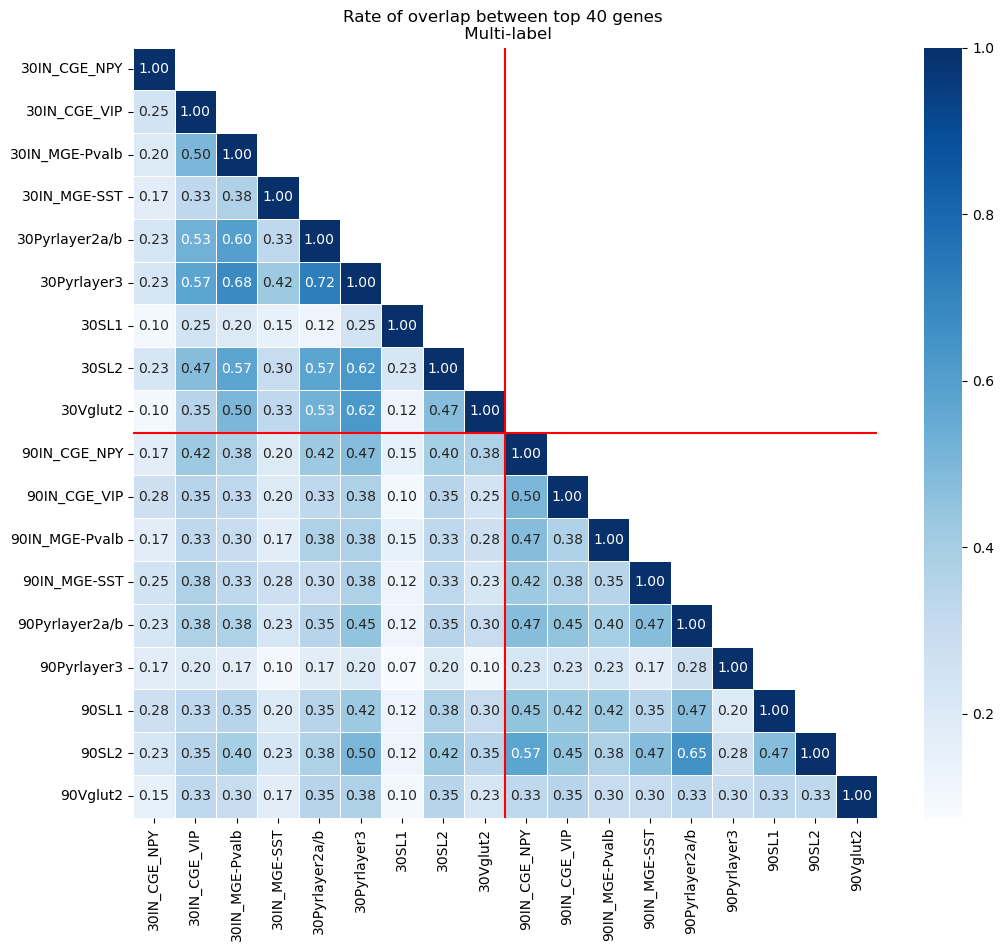

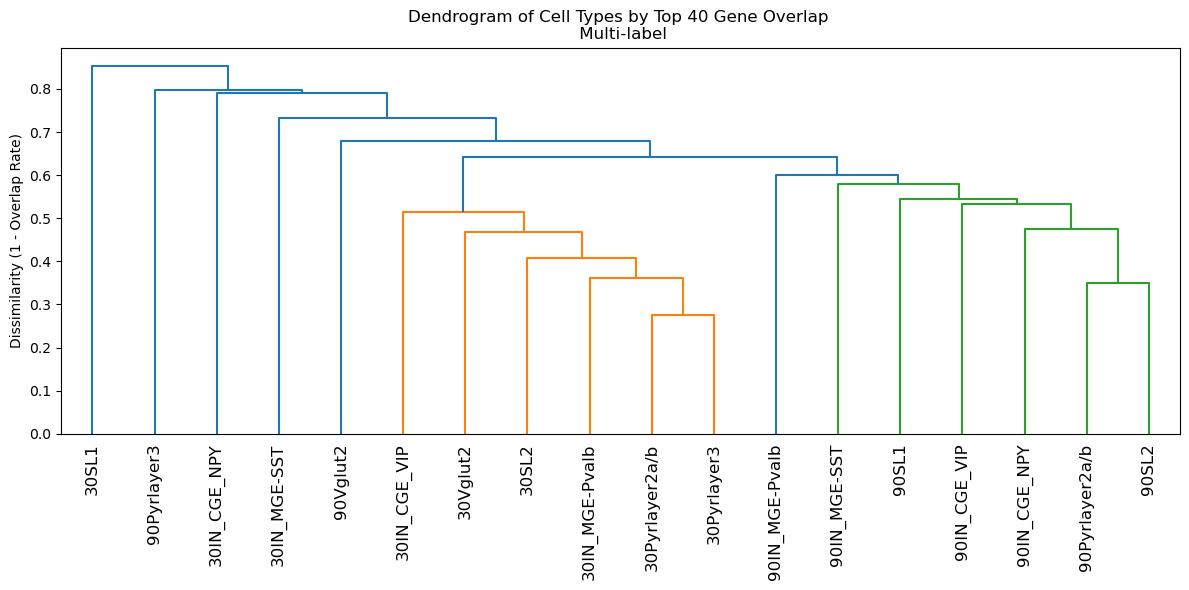

In [8]:
# print(cross_predict30)
# top_features
overlap_rate = pd.DataFrame(index = overlap.columns.tolist())
for col in overlap.columns:
    curr = []
    for other in overlap.columns:
        curr.append(len(set(overlap[col]).intersection(set(overlap[other])))/40)
    overlap_rate[col] = curr

# overlap.columns = [f'{x}: {cross_predict30.loc[x, x].round(2)}' for x in time_mods if x in cross_predict30] + [f'{x}: {cross_predict90.loc[x, x].round(2)}' for x in time_mods if x in cross_predict90]
# overlap.index = [f'{x}: {cross_predict30.loc[x, x].round(2)}' for x in time_mods if x in cross_predict30] + [f'{x}: {cross_predict90.loc[x, x].round(2)}' for x in time_mods if x in cross_predict90]


distance_matrix = 1 - overlap_rate.values

print(overlap_rate)
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(overlap_rate, dtype=bool), k=1)

# Plot the heatmap with the mask
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_rate, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, mask=mask)

plt.title("Rate of overlap between top 40 genes \n Multi-label")
n = len(overlap.columns)
# Determine the middle of the matrix to separate into quadrants
mid_point = n // 2

# Draw horizontal and vertical lines to separate quadrants
plt.hlines(y=mid_point, xmin=0, xmax=n, colors='red', linewidth=1.5)
plt.vlines(x=mid_point, ymin=0, ymax=n, colors='red', linewidth=1.5)

plt.show()

################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# Condense the symmetric distance matrix
condensed = squareform(distance_matrix)

# Create linkage (you can use 'average', 'complete', etc.)
Z = linkage(condensed, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=overlap_rate.columns.tolist(), leaf_rotation=90)
plt.title("Dendrogram of Cell Types by Top 40 Gene Overlap \n Multi-label")
plt.ylabel("Dissimilarity (1 - Overlap Rate)")
plt.tight_layout()
plt.show()



In [41]:
with open(f'../pickles/30min-data/IN_CGE_NPY_shap.pkl', 'rb') as f:
    shap30= pickle.load(f)
with open(f'../pickles/30min-data/IN_CGE_NPY_shap_data_subset.pkl', 'rb') as f:
    shap_samples = pickle.load(f)

with open(f'../pickles/90min-data/IN_CGE_NPY_shap.pkl', 'rb') as f:
    shap90= pickle.load(f)
with open(f'../pickles/90min-data/IN_CGE_NPY_shap_data_subset.pkl', 'rb') as f:
    shap_samples = pickle.load(f)

print(shap30)
print("split")
print(shap90)

[[[ 2.68874550e-03 -2.90100649e-03  2.12258776e-04]
  [ 2.38188615e-04 -8.30169069e-04  5.91971562e-04]
  [ 1.48469012e-03 -6.86601328e-04 -7.98071735e-04]
  ...
  [ 2.13030213e-03 -8.20187852e-04 -1.31011149e-03]
  [ 7.68074387e-05 -9.88368993e-05  2.20286074e-05]
  [ 3.62477876e-04  5.78549551e-03 -6.14792062e-03]]

 [[ 5.47749689e-03 -5.19062160e-03 -2.86879920e-04]
  [-2.11578415e-04 -6.76021329e-04  8.87600065e-04]
  [ 2.05211015e-03 -1.15623116e-03 -8.95879231e-04]
  ...
  [-1.07701309e-02  7.06388615e-03  3.70624615e-03]
  [ 1.14505281e-04 -1.33456415e-04  1.89511065e-05]
  [-3.33716646e-02  3.10191102e-02  2.35254271e-03]]

 [[ 2.68874550e-03 -2.90100649e-03  2.12258776e-04]
  [ 2.38188615e-04 -8.30169069e-04  5.91971562e-04]
  [ 1.48469012e-03 -6.86601328e-04 -7.98071735e-04]
  ...
  [ 2.13030213e-03 -8.20187852e-04 -1.31011149e-03]
  [ 7.68074387e-05 -9.88368993e-05  2.20286074e-05]
  [ 3.62477876e-04  5.78549551e-03 -6.14792062e-03]]

 ...

 [[ 5.47749689e-03 -5.19062160e-03

In [45]:

# 850 x 3000 x 3
# sample 1 predictaed = 0
# 850 x 3000
# in flattening this 850 x 3000 shape, what is the method we should use? 


# # Extract the mean absolute SHAP values for each feature
# mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)

# # Get the indices of the top 110 features
# top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]

# # Extract the feature names for the top 110 features
# top_100_features = [explanation.feature_names[i] for i in top_100_indices]

# print(top_100_features)

# looking at the overlap with the canon iegs and lrgs
lrgs = [
    "Fndc9", "Meox1","Scg2", "Kcnj4","Glt28d2", "Gpr3","Mbnl2", "Trip10","Maml3", "Cd109","Csrnp1", "Gpr63","Sv2c", "Tll1","Hsd17b12", "Bmp3","Crhbp", "Stc1","Col10a1", "Klhl4","Gch1", "Sostdc1","Tac1", "Spred3","Errfi1", "Sowahb","C2cd4b", "Slitrk4","Prok2", "Mfap3l","Slc2a3", "Kcna1","Cartpt", "Fezf2","Kcnj3", "Dennd2c","Chrm2", "Stc2","Mlf1", "Hdac9", "Dusp4", "Hunk","Popdc3", "Pthlh","Ccdc184", "Pnoc","Dusp14", "Kcnh8","Kcnf1", "Acan","Alpk1", "Gper1","Rgs2", "Omg","Wdr90", "Chac1","Grasp", "Stac","Coq10b", "Nptx2","Fam126b", "Kcna4","Mctp2", "Sema3e","Bdnf", "Palmd", "Gem", "Rab39","Tiparp", "Serpinb2","Gpr22", "Hspb3","Pcsk1", "5430416O09Rik","Cystm1", "9430020K01Rik","Ptgs2", "Dmxl1", "Per1", "Cdkn1a", "Ptger4", "Fbxo33", "Adm", "Sik1","Pax1", "Crem","Pou3f1", "Spty2d1","Chst8", "Tbc1d8b","Pgap1", "Zdbf2","Lipg", "Bves", "Adcyap1", "Chml","Slc7a1", "Klf14", "Pcdh8", "Rgs4", "Areg", "Rnf128","Nap1l5", "Peg10","Tnn", "Nr4a3","Stk40", "Atp10d","Rel", "Slc6a17","Slc40a1", "Mthfd2","Brinp1", "Nrn1","Per2", "Msantd1","Rem2", "Gprc5a","Eprs", "Pam","Sertad1", "Tacr3","Hcrtr2", "Herpud1","Stard4", "Nppc","Pard6a", "Plagl1","Pcdh20", "Osgin2","Mpp7", "Kcns2","Cort", "Sstr2","Ell2", "Gpr26","Sult2b1", "Rheb","Acsl4", "Nr4a2","Nefl", "Fosl2","Tec", "Fam46a","Gmeb2", "Rasgrp1", "Gltscr2", "Atf3", "Kitl", "Baz1a", "Npbwr1", "4931440P22Rik", "Cfap43", "D16Ertd472e"
]
iegs = [
    "Fos", "Fosb", "Fosl1", "Fosl2", "Jun", "Junb", "Jund", "Egr1", "Egr2", "Egr3", "Egr4",
    "Nr4a1", "Nr4a2", "Nr4a3", "Arc", "Homer1", "Rheb", "Rgs2", "Plk2", "Ptgs2", "Bdnf", "Inhba",
    "Nptx2", "Plat", "Nrn1", "Myc", "Dusp1", "Dusp5", "Dusp6", "Pcdh8", "Cyr61", "Gadd45b",
    "Trib1", "Gem", "Btg2", "Ier2", "Npas4", "Rasd1", "Crem", "Mbnl2", "Arf4", "Gadd45g", "Arih1",
    "Nup98", "Ppp1r15a", "Fbxo33", "Per1", "Per2", "Maff", "Zfp36", "Srf", "Mcl1", "Ctgf", "Il6",
    "Atf3", "Rcan1", "Ncoa7", "Cxcl2", "Bhlhe40", "Slc2a3", "Nfkbia", "Ier3", "Sgk1", "Klf6",
    "Klf10", "Nfkbiz", "Flg", "Gbp2b", "Tnfaip3", "Cebpd", "Hbegf", "Ldlr", "Tsc22d1", "F3",
    "Ccl2", "Csrnp1", "Pmaip1", "Zfp36l2", "Plau", "Ccl5", "Saa3", "Ifnb1", "Tnf", "Irf1",
    "Cd83", "Map3k8", "Socs3", "Csf2", "Il1a", "Cxcl1", "Il12b", "Il1b", "Sod2", "Pim1",
    "Peli1", "Tlr2", "Ccl3", "Noct", "Bcl3", "Ifit2", "Icam1", "Ifit1", "Tnfsf9", "Ccrl2",
    "Cxcl10", "Gbp2", "Il10", "Clec4e", "Acod1", "Mmp13", "Cxcl11", "Il23a", "Arhgef3",
    "Serpine1", "Traf1", "Vcam1", "Ackr4", "Marcksl1", "Nfkbid", "Ikbke", "Ccl12", "Ifit3",
    "Cebpb", "Zfp36l1", "Txnip", "Nfib", "Hes1", "Pias1", "Klf2", "Cd69", "Dusp2", "Wee1",
    "Thbs1", "Sik1", "Gdf15", "Ier5", "Rgs1", "Id2", "Apold1", "Egr4", "Fosb", "Npas4",
    "Fos", "Btg2", "Ier2", "Amigo3", "Egr3", "Dusp1", "Klf4", "Arc", "Gadd45g", "Ppp1r15a",
    "Egr2", "Dusp5", "Maff", "Junb", "Nr4a1", "Egr1"
]

def extract_shap(explanation):
    # # Extract the mean absolute SHAP values for each feature
    print(explanation.values)
    mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
    print(mean_abs_shap_vals)
    
    # Get the indices of the top 110 features
    top_100_indices = np.argsort(mean_abs_shap_vals)[:][::-1]
    
    # Extract the feature names for the top 110 features
    features = [explanation.feature_names[i] for i in top_100_indices]
    for i, f in enumerate(features):
        if f in lrgs:
            print(f'lrg: {f},{i}')
        if f in iegs:
            print(f'ieg: {f},{i}')

    
print(explanation30.shape)
extract_shap(explanation30)


(896, 3000)
[[ 5.92877250e-03 -7.70880317e-04  4.98951646e-04 ...  2.14009383e-03
   2.12143874e-04  2.56130025e-02]
 [ 2.90187378e-03 -4.10361652e-04 -6.81975565e-04 ...  7.87490630e-04
   1.35692346e-04 -2.75944844e-02]
 [ 3.60952900e-03 -5.31865226e-04  7.90348058e-05 ...  2.19511450e-03
   1.76619549e-04 -3.38256955e-02]
 ...
 [ 1.77265238e-03  2.77453661e-03  3.53976004e-02 ...  2.80015776e-03
  -2.42647380e-04  4.17957604e-01]
 [ 1.43996545e-03 -6.18916762e-04 -9.88796237e-04 ...  1.47016081e-05
   2.48169272e-05  1.43849710e-02]
 [ 2.83131562e-03  2.81180779e-04 -1.39921351e-04 ...  2.19324735e-04
  -5.53602695e-05 -1.17199402e-03]]
[0.00589678 0.00121971 0.0070063  ... 0.00276743 0.00015373 0.05466936]
lrg: Pgap1,129
ieg: Nfib,167
lrg: Chrm2,250
lrg: Rgs4,257
lrg: Maml3,269
lrg: Omg,288
lrg: Bdnf,306
ieg: Bdnf,306
lrg: Chst8,401
lrg: Nap1l5,404
lrg: Nptx2,410
ieg: Nptx2,410
lrg: Slitrk4,444
ieg: Junb,453
ieg: Jund,459
lrg: Kcnf1,472
lrg: Nrn1,476
ieg: Nrn1,476
ieg: Egr1,483
ieg

In [13]:
# printing to a csv

import pandas as pd
# Extract the feature names and their corresponding mean absolute SHAP values for the top 110 features
top_100_features = [explanation.feature_names[i] for i in top_100_indices]
top_100_values = [mean_abs_shap_vals[i] for i in top_100_indices]

# Create a DataFrame
top100_df =  pd.DataFrame({
    'Aggregate SHAP': top_100_features
})

# # Save to CSV
# top_110_df.to_csv('top_110_features_new.csv', index=False)

# Section 3: SHAP by cluster


In [5]:
top_features = pd.read_csv("../csvs/top_features.csv")
print(top_features)
average_expressions_df = pd.DataFrame()
print(data)

for t in ["30", "90"]:
    print(data[t][2][0])

    for c in data[t][2][0].obs['cell_type_lvl_2']:
        cluster_samples = data[t][2][0][data[t][2][0].obs['cell_type_lvl_2'] == c]
        cluster_values = []
        
        for gene in top_features[f'{t}min: aggregate']:
            gene_index = None
            if gene in cluster_samples.var.index:
                gene_index = cluster_samples.var.index.get_loc(gene)
        
            if gene_index is None:
                cluster_values.append(0)
                continue
    
            gene_expression_values = cluster_samples.X[:, gene_index]
            mean_expression = np.mean(gene_expression_values)
            
        
            cluster_values.append(mean_expression)


        average_expressions_df[c] = cluster_values
        
    average_expressions_df["genes"] = top_features[f'{t}min: aggregate']
    var = []
    for _, row in average_expressions_df.iterrows():
        var.append(np.var(list(row[0:6])))
    average_expressions_df["var"] = var
    average_expressions_df.to_csv(f"{t}min_mean_variance_expressions.csv")


print(average_expressions_df)


    Unnamed: 0 30min: aggregate 90min: aggregate
0            0            Ikzf1       AC149090.1
1            1          Arhgap6            Spry3
2            2             P3h4             Tns3
3            3              Cnp              Jup
4            4       AC149090.1            Ikzf1
5            5             Vwc2              Cnp
6            6            Nxpe2             P3h4
7            7          Proser2              Ina
8            8            Apoa1            Fxyd6
9            9          Slc11a1           Pdcd11
10          10            Fxyd6            Nxpe2
11          11              Jup             Vwc2
12          12             Tns3          Arhgap6
13          13           Pdcd11            Apoa1
14          14           Usp6nl             Arsa
15          15            Spry3            Mapk4
16          16            Matn2           Atp5md
17          17            Rpl30             Eps8
18          18            Ccnd1          Mov10l1
19          19      

    Unnamed: 0 30min: aggregate 90min: aggregate
0            0            Ikzf1       AC149090.1
1            1          Arhgap6            Spry3
2            2             P3h4             Tns3
3            3              Cnp              Jup
4            4       AC149090.1            Ikzf1
5            5             Vwc2              Cnp
6            6            Nxpe2             P3h4
7            7          Proser2              Ina
8            8            Apoa1            Fxyd6
9            9          Slc11a1           Pdcd11
10          10            Fxyd6            Nxpe2
11          11              Jup             Vwc2
12          12             Tns3          Arhgap6
13          13           Pdcd11            Apoa1
14          14           Usp6nl             Arsa
15          15            Spry3            Mapk4
16          16            Matn2           Atp5md
17          17            Rpl30             Eps8
18          18            Ccnd1          Mov10l1
19          19      

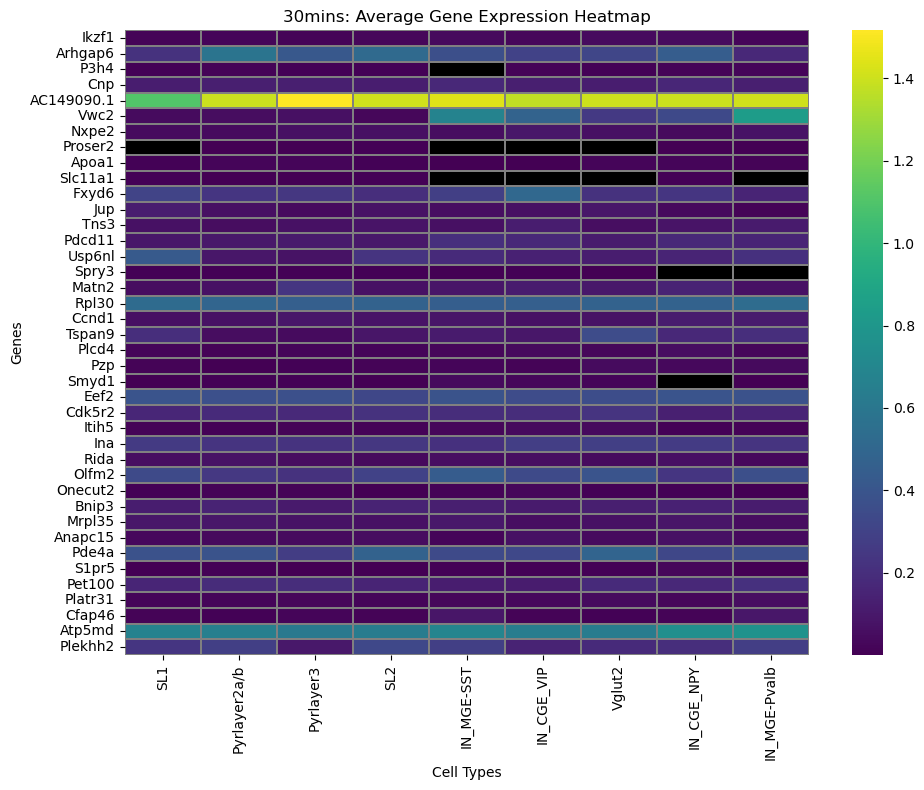

                 SL1  Pyrlayer2a/b  Pyrlayer3       SL2  IN_MGE-SST  \
genes                                                                 
AC149090.1  0.720269      0.903266   1.044920  0.845357    0.975521   
Spry3       0.009575      0.003274   0.004680  0.005592    0.008349   
Tns3        0.055462      0.057589   0.066196  0.065281    0.096108   
Jup         0.134602      0.045580   0.032998  0.055049    0.044882   
Ikzf1       0.019158      0.019744   0.016548  0.012492    0.025039   
Cnp         0.091673      0.110688   0.122580  0.106401    0.133765   
P3h4        0.009923      0.008211   0.011034  0.017736    0.017857   
Ina         0.242747      0.231940   0.214231  0.277326    0.211225   
Fxyd6       0.285978      0.222578   0.216559  0.281424    0.264411   
Pdcd11      0.108075      0.087987   0.100878  0.097807    0.153862   
Nxpe2       0.046482      0.072005   0.100465  0.079954    0.071580   
Vwc2        0.026093      0.051390   0.056831  0.014070    0.641432   
Arhgap

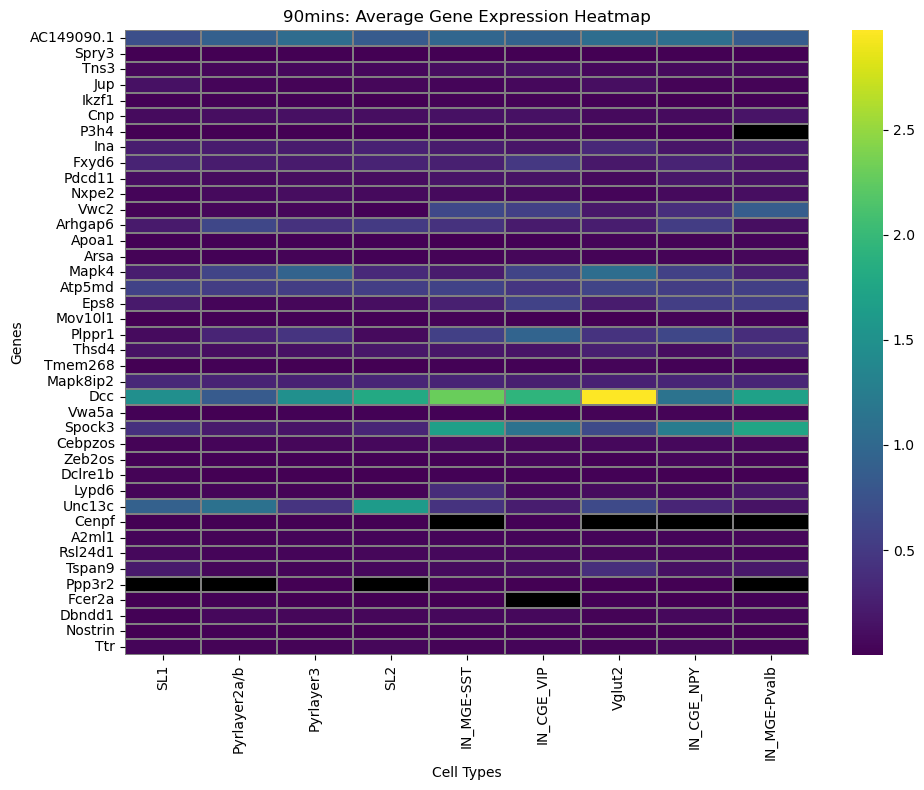

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, Normalize
print(top_features)
for t in ["30", "90"]:
    df = pd.read_csv(f"{t}min_mean_variance_expressions.csv", index_col=0)
    data = df.drop(columns=["genes", "var",])
    # data = df[:, 1:10]
    data.index = df["genes"]
    print(data)

    # Create a mask for zeros and non-zeros
    zero_mask = (data == 0)
    nonzero_mask = ~zero_mask
    
    # Create a figure and axis
    plt.figure(figsize=(10, 8))
    
    # Plot non-zero values using a standard colormap
    sns.heatmap(data.where(nonzero_mask), cmap="viridis", cbar=True, linewidths=0.1, linecolor='gray')
    
    # Overlay zero values using black
    sns.heatmap(data.where(zero_mask), cmap=ListedColormap(["black"]), cbar=False, linewidths=0.1, linecolor='gray')
    
    plt.title(f"{t}mins: Average Gene Expression Heatmap")
    plt.xlabel("Cell Types")
    plt.ylabel("Genes")
    plt.tight_layout()
    plt.show()

In [10]:
# By leiden cluster: Generate a shap plot

# top50_df = pd.DataFrame()
feature_names = m30_test.var.index.tolist()
cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}

def generate_cell_type_shap(which_model, model):
    for j in range(6):
        print(j)
        with open(f'../pickles/{which_model}-data/leiden_cluster_{j}_shap.pkl', 'rb') as f:
            leiden_shap = pickle.load(f)
        with open(f'../pickles/{which_model}-data/leiden_cluster_{j}_shap_data_subset.pkl', 'rb') as f:
            leiden_shap_sample = pickle.load(f)
        
        shap_vals = np.squeeze(leiden_shap)
        
        preds = model.predict(leiden_shap_sample)
        preds = np.argmax(tf.nn.softmax(preds, axis = 1), axis = 1)
        print(preds)
        
        new_shap_vals = []
        for i, pred in enumerate(preds):
            new_shap_vals.append(shap_vals[i][:, pred])
        
        new_shap_vals = np.array(new_shap_vals)
        
        explanation = shap.Explanation(new_shap_vals, feature_names = feature_names)
    
        # Extract the mean absolute SHAP values for each feature
        mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
        
        # Get the indices of the top 110 features
        top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]
        
        # Extract the feature names for the top 110 features
        top_100_features = [explanation.feature_names[i] for i in top_100_indices]
    
        # top100_df[f'{cluster_decode[j]}'] = top_100_features
        
    
        shap.plots.bar(explanation, max_display = 10, show = False)
        plt.title(f'{which_model} {cluster_decode[j]} shap plot')
        plt.show()
generate_cell_type_shap("30min", model30)
generate_cell_type_shap("90min", model90)

NameError: name 'm30_test' is not defined

In [16]:
print(top100_df)

    Aggregate SHAP Pyramidal layer2a/b Pyramidal layer3 Deep Pyramidal  \
0            Lars2            AY036118       AC149090.1     AC149090.1   
1       AC149090.1               Lars2             Cdk8       AY036118   
2             Cdk8          AC149090.1            Lars2          Lars2   
3         AY036118                Cdk8         AY036118          Cmss1   
4            Cmss1               Cmss1            Cmss1           Cdk8   
..             ...                 ...              ...            ...   
96           Pdzd2                 Mt1            Stmn1          Vsnl1   
97           Erbb4                Ahi1              Mt1          Kcnd2   
98            Nrgn               Vamp2            Rps21         Cox4i1   
99          Rpl37a               Megf9            Ndst4         Brinp3   
100          Atp5k               Rps21             Eps8           Wwc1   

      Semilunar Inhibitory1 Inhibitory2  
0    AC149090.1    AY036118       Lars2  
1         Lars2  AC149090.1

0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[4 0 0 0 0 0 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 3 0 0 5
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 4 0 3 0 0 0 0 0 0 3 0 3 0 0 0 1 0 0 0 0]


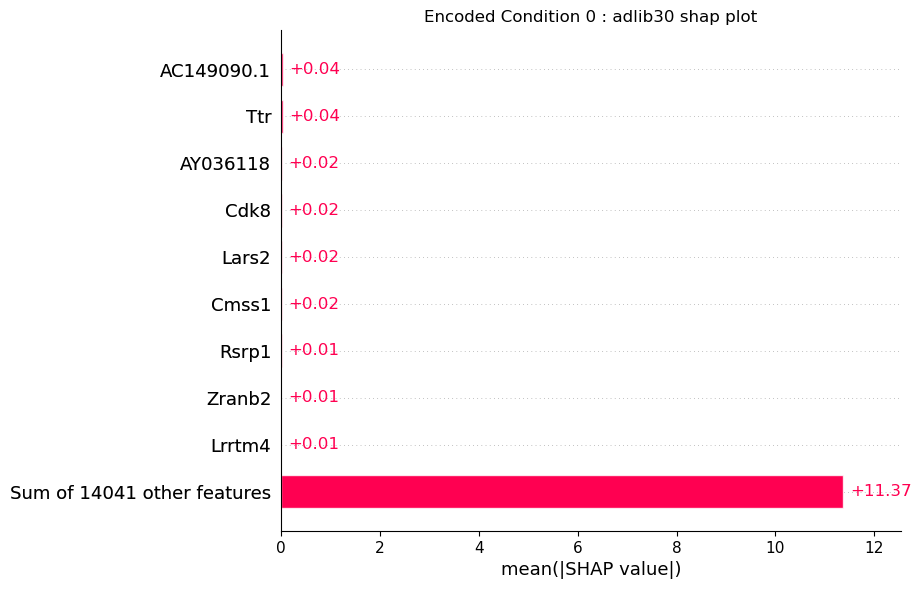

1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 7 1 1 4
 1 1 1 4 1 1 7 1 1 1 2 1 4 4 1 3 1 1 1 5 4 1 1 1 4 1 1 1 1 1 1 1 4 1 1 2 1
 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


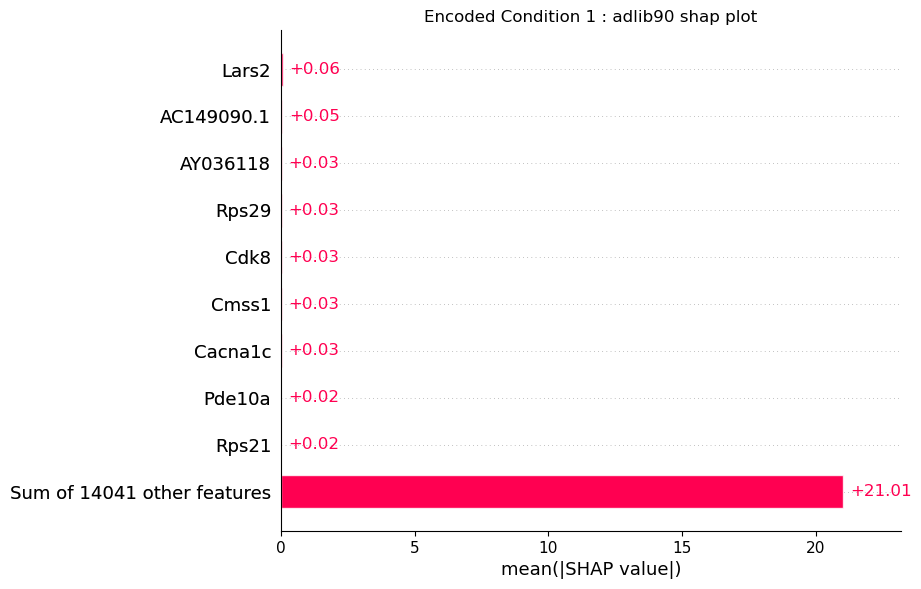

2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7]


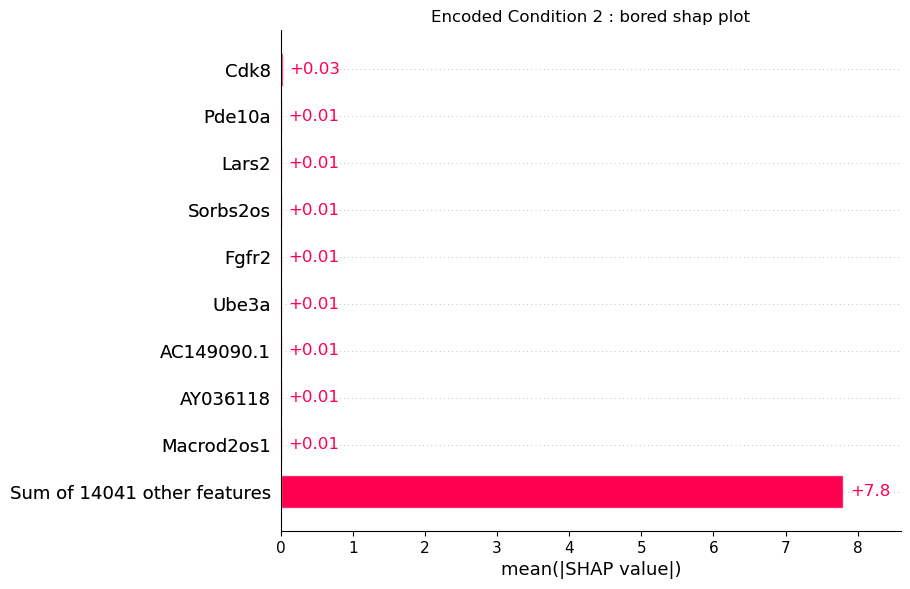

3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[3 7 7 7 3 7 3 3 0 7 3 3 3 7 3 7 3 3 3 7 3 3 3 3 3 3 3 3 3 3 7 7 3 3 7 3 3
 3 3 7 3 3 3 3 7 3 3 3 3 3 3 3 3 7 3 3 7 3 3 3 3 7 7 3 7 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 3 7 3 7 3 3 7 3 3 7 3 7 3 7 3 3 7]


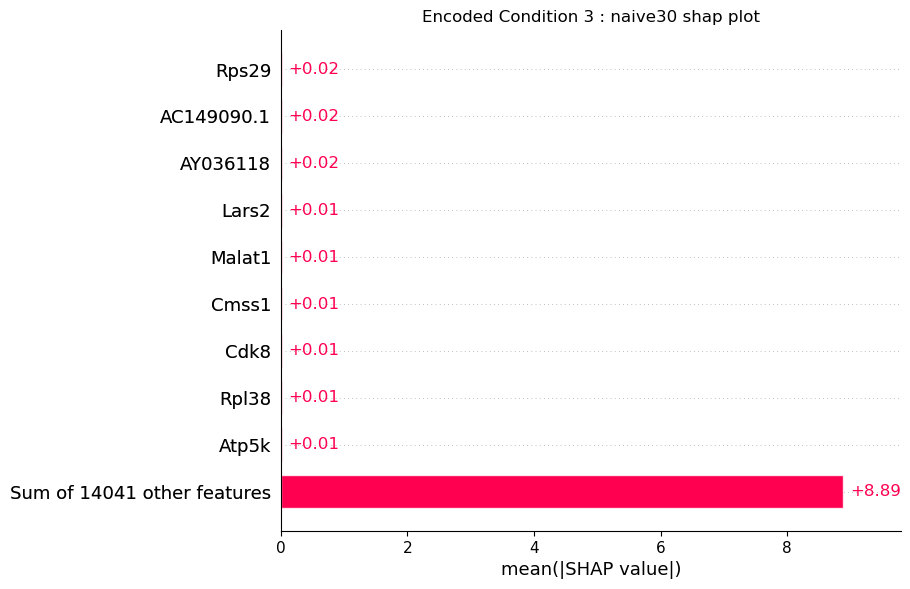

4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[4 0 2 1 4 4 4 4 1 4 4 2 4 4 4 4 8 4 1 3 4 7 4 4 4 1 4 1 4 5 4 1 1 4 1 4 2
 4 4 4 4 4 4 4 4 4 5 4 4 1 4 4 4 4 4 1 3 4 4 3 0 4 4 5 4 4 2 1 4 8 4 4 5 4
 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 5 4 1 4 4 4 4 4 4]


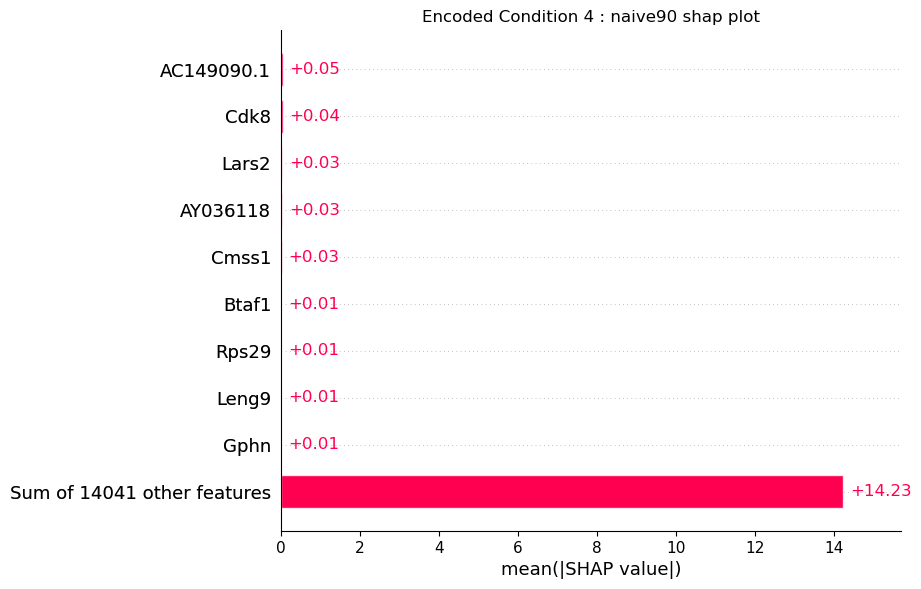

5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[1 5 5 5 4 5 5 5 5 5 0 5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 1 5 0 5 5 5 5 5 5 5 5
 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 8 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 4 5 5 1 5 7 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5]


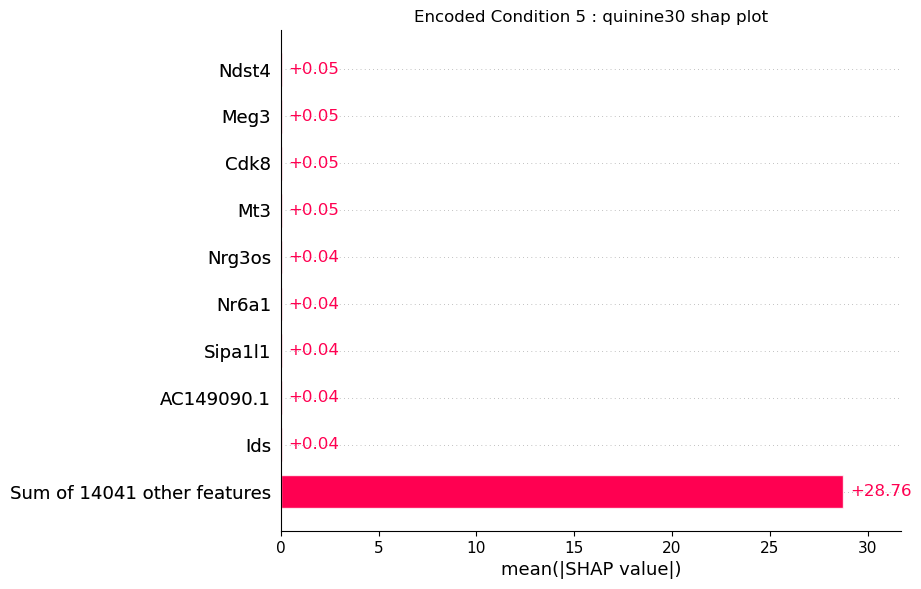

6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[6 6 6 6 6 6 6 6 6 6 6 6 6 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4
 6 6 6 6 6 6 6 6 6 6 3 6 6 6 8 6 6 7 6 6 6 6 7 6 6 7 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 7 6 6 6 6 6 6 6 6 7 6 6 6 7 8 6 7 7 6 6]


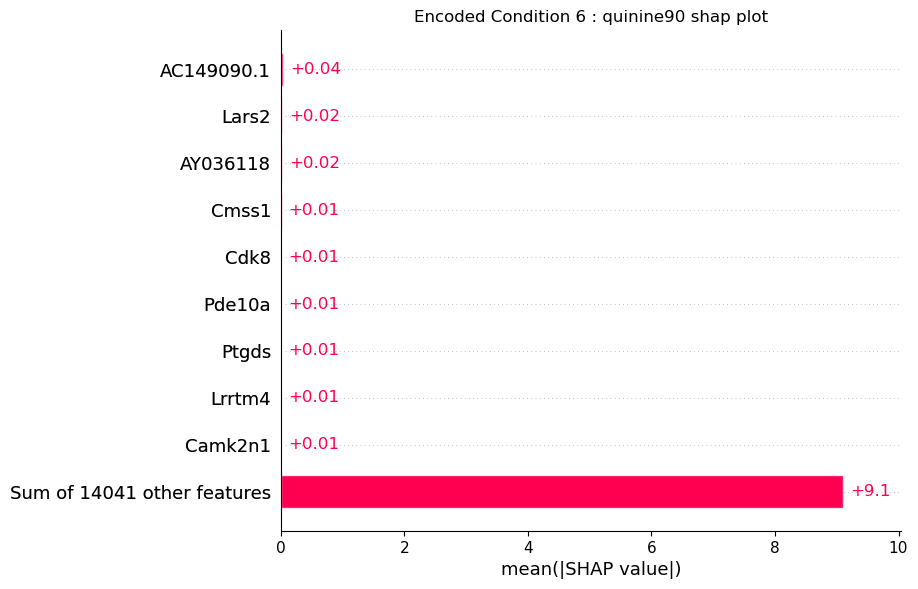

7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[7 7 7 7 7 7 7 7 7 3 7 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 5 7
 5 7 7 7 7 7 3 3 7 7 7 7 7 7 7 5 3 7 7 7 7 7 7 7 0 7 7 7 4 7 7 7 3 7 7 7 3
 7 7 7 7 7 7 7 7 7 7 7 7 7 3 7 7 7 7 7 7 7 7 7 5 7 7]


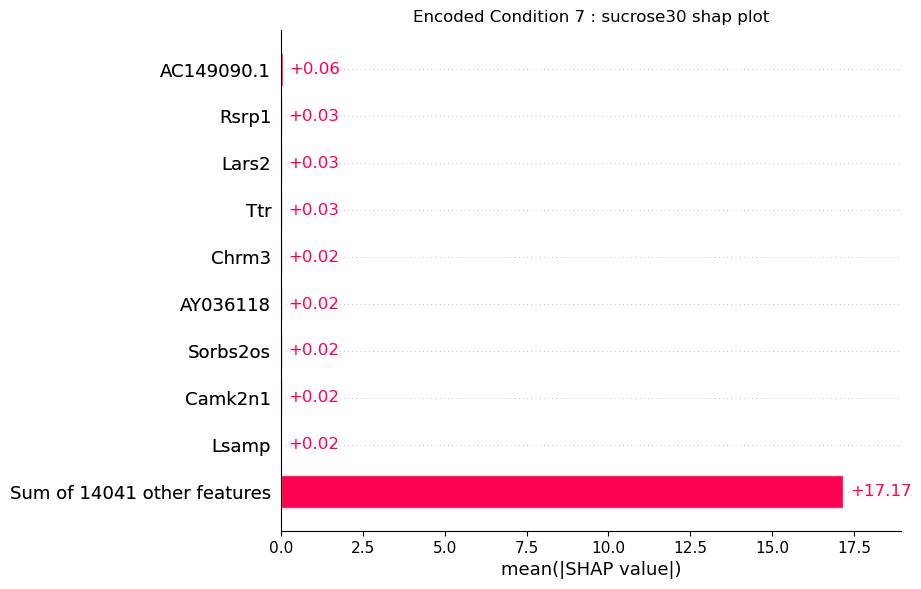

8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6 6 8 8 8 8 8 8 8 8 8 8 1 8 8 8 6 4 8
 8 8 8 8 8 8 8 8 8 8 7 8 8 8 8 8 8 8 8 6 8 8 8 8 8 8]


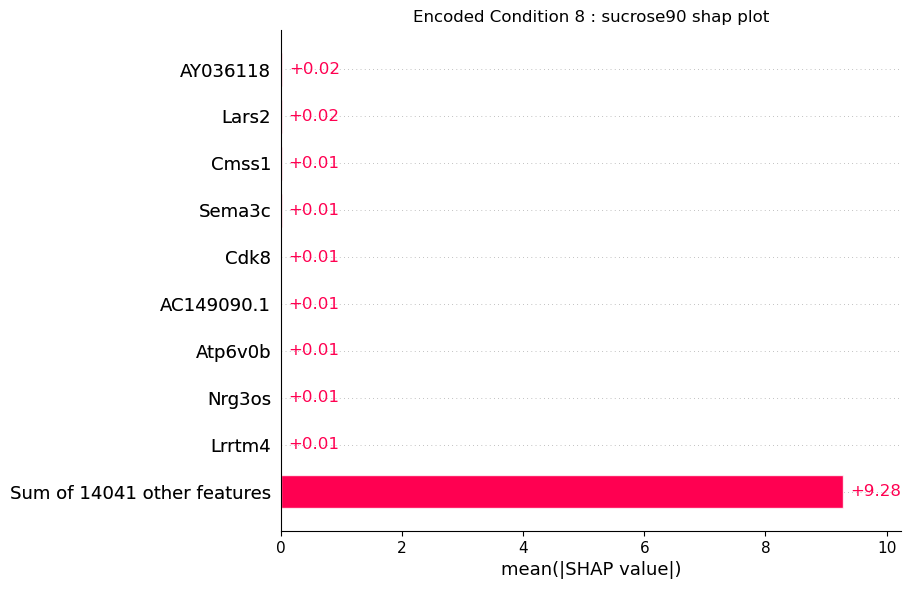

In [17]:
for j in range(9):
    print(j)
    with open(f'encoded_condition_{j}_shap.pkl', 'rb') as f:
        leiden_shap = pickle.load(f)
    with open(f'encoded_condition_{j}_shap_data_subset.pkl', 'rb') as f:
        leiden_shap_sample = pickle.load(f)
    
    shap_vals = np.squeeze(leiden_shap)
    
    preds = model.predict(leiden_shap_sample)
    preds = np.argmax(tf.nn.softmax(preds, axis = 1), axis = 1)
    print(preds)
    
    new_shap_vals = []
    for i, pred in enumerate(preds):
        new_shap_vals.append(shap_vals[i][:, pred])
    
    new_shap_vals = np.array(new_shap_vals)
    
    explanation = shap.Explanation(new_shap_vals, feature_names = feature_names)

    # Extract the mean absolute SHAP values for each feature
    mean_abs_shap_vals = np.mean(np.abs(explanation.values), axis=0)
    
    # Get the indices of the top 110 features
    top_100_indices = np.argsort(mean_abs_shap_vals)[-101:][::-1]
    
    # Extract the feature names for the top 110 features
    top_100_features = [explanation.feature_names[i] for i in top_100_indices]
    
    top100_df[condition_mapping.loc[j, 'Original Condition']] = top_100_features
    
    shap.plots.bar(explanation, max_display = 10, show = False)
    plt.title(f'Encoded Condition {j} : {condition_mapping.loc[j, "Original Condition"]} shap plot')
    plt.show()

In [19]:
top100_df.to_csv('top_100_features_new.csv', index=False)

In [18]:
top100_df

,Aggregate SHAP,Pyramidal layer2a/b,Pyramidal layer3,Deep Pyramidal,Semilunar,Inhibitory1,Inhibitory2,adlib30,adlib90,bored,naive30,naive90,quinine30,quinine90,sucrose30,sucrose90
0,Lars2,AY036118,AC149090.1,AC149090.1,AC149090.1,AY036118,Lars2,AC149090.1,Lars2,Cdk8,Rps29,AC149090.1,Ndst4,AC149090.1,AC149090.1,AY036118
1,AC149090.1,Lars2,Cdk8,AY036118,Lars2,AC149090.1,AC149090.1,Ttr,AC149090.1,Pde10a,AC149090.1,Cdk8,Meg3,Lars2,Rsrp1,Lars2
2,Cdk8,AC149090.1,Lars2,Lars2,Cdk8,Lars2,AY036118,AY036118,AY036118,Lars2,AY036118,Lars2,Cdk8,AY036118,Lars2,Cmss1
3,AY036118,Cdk8,AY036118,Cmss1,AY036118,Cmss1,Cdk8,Cdk8,Rps29,Sorbs2os,Lars2,AY036118,Mt3,Cmss1,Ttr,Sema3c
4,Cmss1,Cmss1,Cmss1,Cdk8,Cmss1,Cdk8,Cmss1,Lars2,Cdk8,Fgfr2,Malat1,Cmss1,Nrg3os,Cdk8,Chrm3,Cdk8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Pdzd2,Mt1,Stmn1,Vsnl1,Auts2,Spred2,Fus,Pigk,Sez6l,Rimbp2,Pnisr,Rab3c,Lsamp,Cdyl2,Fbxl5,Alcam
97,Erbb4,Ahi1,Mt1,Kcnd2,Il1rapl1,Lrrtm4,Nptxr,Slit3,Sik3,Klf7,Nmt2,Dnajc1,Mir670hg,Camk4,Nrg3os,Rpl41
98,Nrgn,Vamp2,Rps21,Cox4i1,Ndrg4,Hecw2,Gria1,Dpp6,Ttll7,Syt7,Epb41l1,Gria1,Ifi35,Ctxn1,Mir9-3hg,Rpl21
99,Rpl37a,Megf9,Ndst4,Brinp3,Slc2a13,Galnt1,Ndst4,Slc4a10,Dpysl2,Otud7a,Pld3,Snhg11,Larp1,Sorcs2,Agrp,Cntnap5a


# Heatmap (x = cell type, y = top50 genes)

In [8]:
import pandas as pd

cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}






# Read in top 50 features for each cell type, find union of all top 50 features
top_50df = pd.read_csv('top_100_features_new.csv')
top_50_union = {}
for i in X_test.obs['leiden'].unique():
    print(f"Leiden cluster: {i}")
    cluster_samples = X_test[X_test.obs['leiden'] == i]
    # print(cluster_samples)
    for j in range(len(top_50df[cluster_decode[int(i)]])):
        if j < 50:
            if i not in top_50_union:
                top_50_union[top_50df[cluster_decode[int(i)]][j]] = 0
            top_50_union[top_50df[cluster_decode[int(i)]][j]] += 1
        else: 
            continue
union50 = sorted(list(top_50_union.keys()), reverse = True,  key = lambda x : top_50_union[x])

union50csv = pd.DataFrame()

union50csv['union50'] = union50


union50csv.to_csv('top_101_features.csv', index=False)
# union50 = union50[:50]



Leiden cluster: 3
Leiden cluster: 6
Leiden cluster: 2
Leiden cluster: 1
Leiden cluster: 8
Leiden cluster: 0
Leiden cluster: 4
Leiden cluster: 5
Leiden cluster: 7


In [18]:
cluster_decode = {
    0 : "Pyramidal layer2a/b",
    1 : "Pyramidal layer3",
    2 : "Deep Pyramidal",
    3 : "Semilunar",
    4 : "Inhibitory1",
    5 : "Inhibitory2",
    6 : "Contamination1",
    7 : "Contamination2",
    8 : "Pappa2"
}
# Step 1: Read the CSV file into a Pandas DataFrame
df = pd.read_csv('top_50_features_new.csv')
df = df[[cluster_decode[int(x)] for x in X_test.obs['leiden'].unique()]]
df = df.head(50)

# Step 2: Combine all columns into one mega column (flattening)
mega_column = pd.Series(df.values.ravel()).drop_duplicates().reset_index(drop=True)

# # Step 3: Remove duplicates and drop NaN values (if any)
mega_column_unique = mega_column.drop_duplicates().dropna()

# Optionally convert it back into a DataFrame with one column
df_mega = pd.DataFrame(mega_column_unique, columns=['Mega_Column'])

# Step 4: Save or print the result

df_mega.to_csv('output.csv', index=False)
union50= list(mega_column)
union50 = [x for x in union50 if x != "Malat1"]

In [35]:
# print(mega_column)
# union50 = [gene for gene in mega_column if not (gene.startswith('Gm') or gene.startswith('mt-') or 'Rik' in gene)][:51]
# print(union50)
# print(len(union50))

0         Gm42418
1      AC149090.1
2           Lars2
3            Cdk8
4        AY036118
          ...    
160         Rps18
161       Cacna1c
162         Kcnn3
163       Gm11417
164         Rgs17
Length: 165, dtype: object
['AC149090.1', 'Lars2', 'Cdk8', 'AY036118', 'Ttr', 'Malat1', 'Cmss1', 'Spred2', 'Rps21', 'Ptgds', 'Brinp2', 'Son', 'Rps29', 'Pde10a', 'Lrrtm4', 'Rbfox1', 'Nptxr', 'Gfod1', 'Phactr1', 'Adarb2', 'Zranb2', 'Sema3c', 'Dpp10', 'Atp6v0b', 'Trim9', 'Rps28', 'Brd9', 'Myt1l', 'Atp6v0c', 'Btaf1', 'Sorbs2os', 'Gphn', 'Hivep2', 'Gpc5', 'Scn2a', 'Erbb4', 'Camk1d', 'Ide', 'Apoe', 'Cst3', 'Grip1', 'Kcnma1', 'Nrg3os', 'Lncpint', 'Nxph1', 'Ubash3b', 'Ncam2', 'Camk2n1', 'Cox7c', 'Tafa1', 'Rpl37']
51


In [9]:
order_conversion = {
    2: 0, 
    3: 1, 
    4: 2,
    0: 3, 
    1: 4, 
    7: 5, 
    8: 6, 
    5: 7, 
    6: 8, 
}
order_conversion = order_conversion.keys()
print(order_conversion)

dict_keys([2, 3, 4, 0, 1, 7, 8, 5, 6])


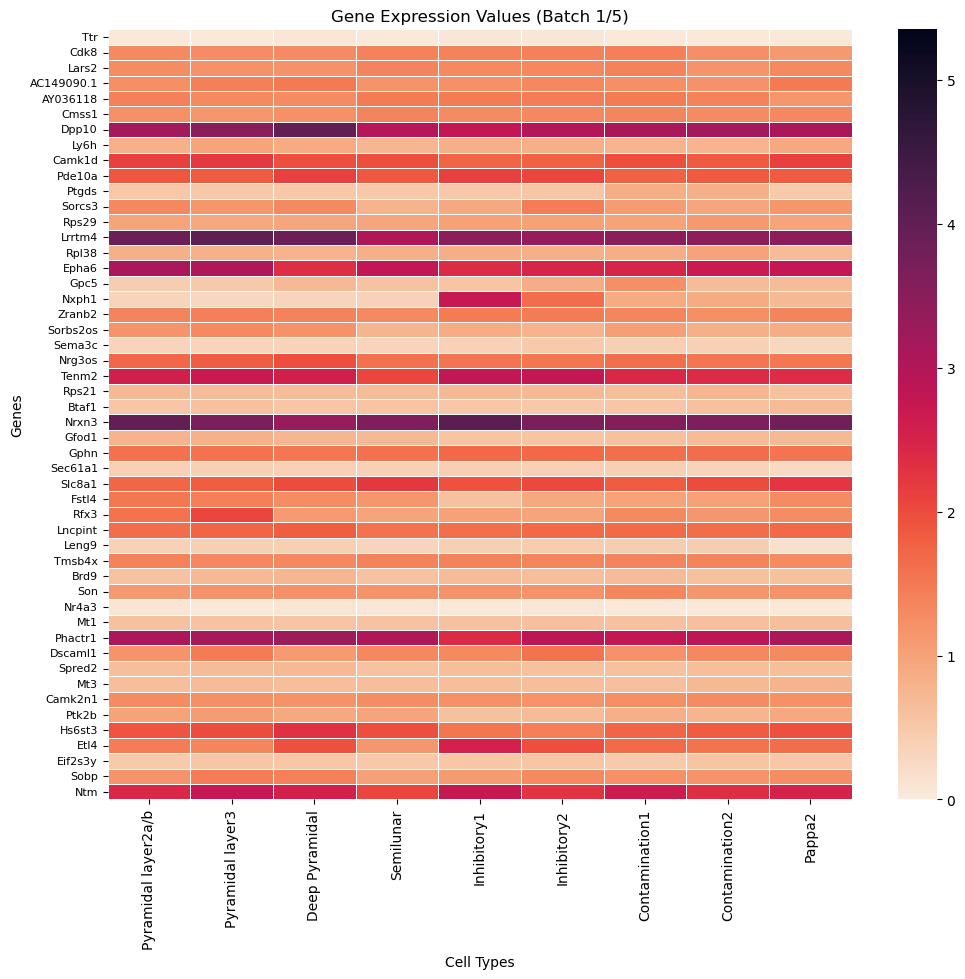

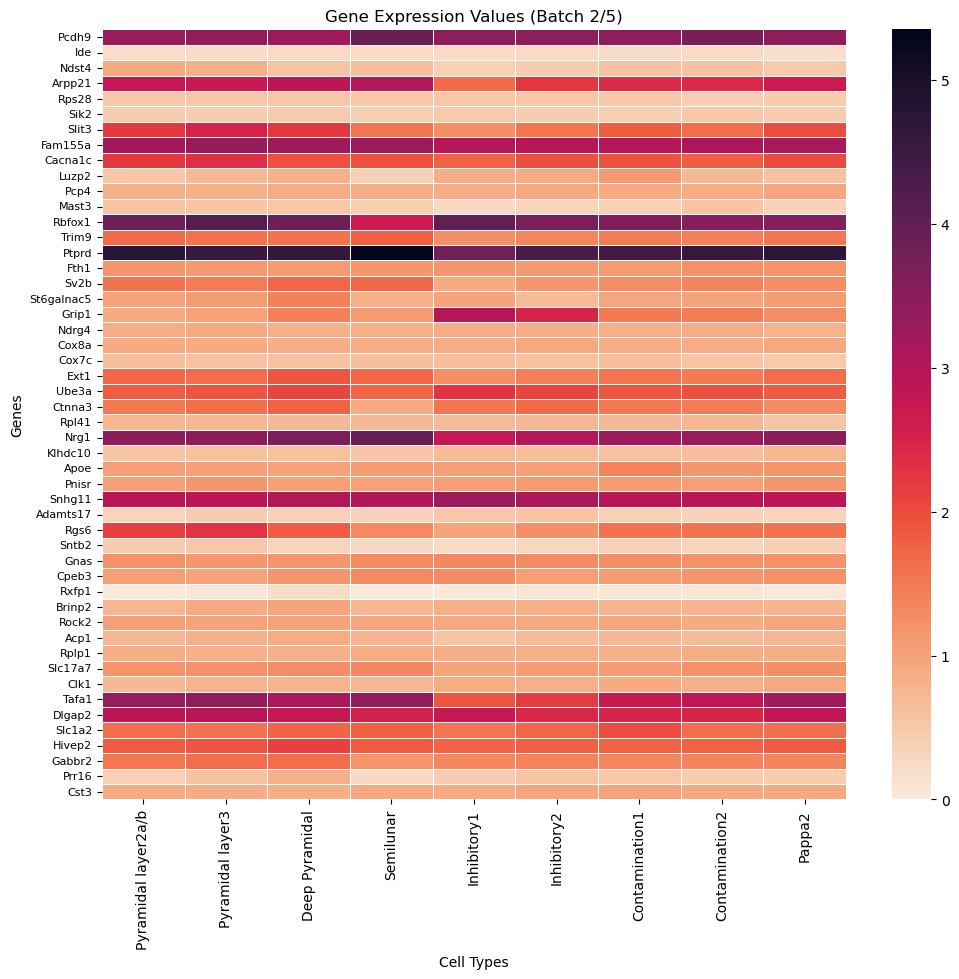

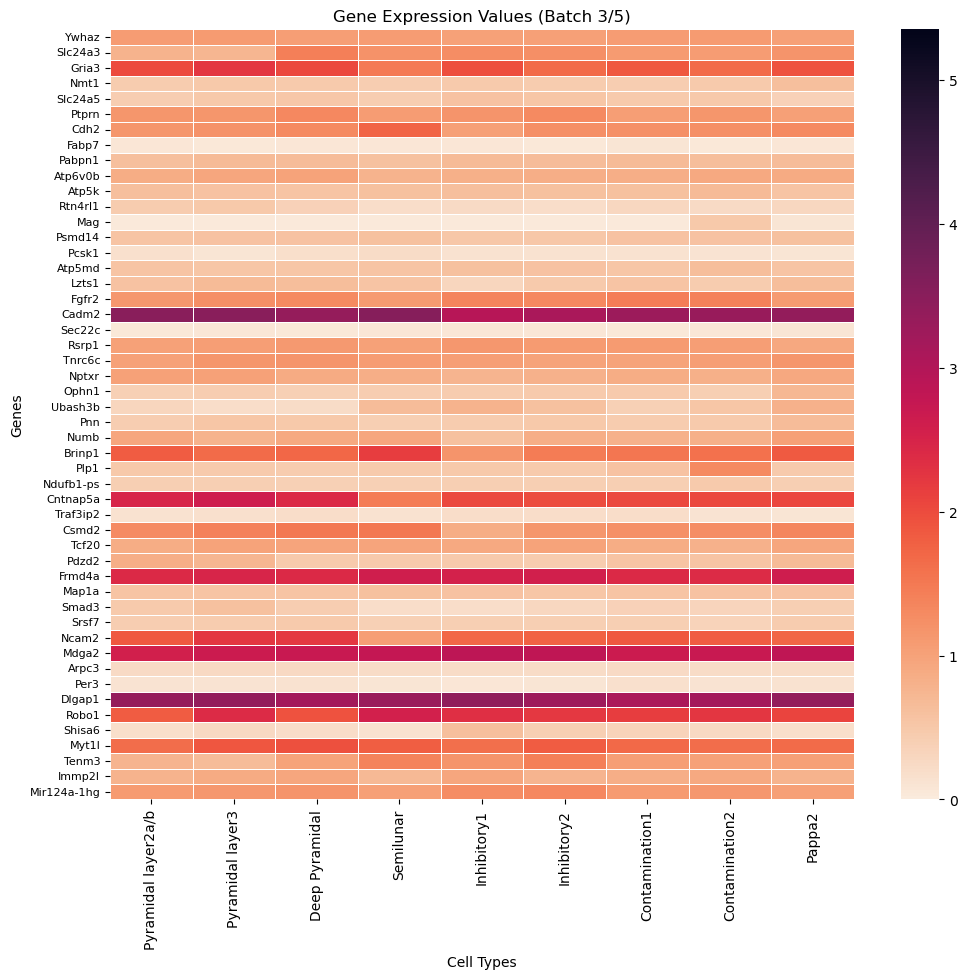

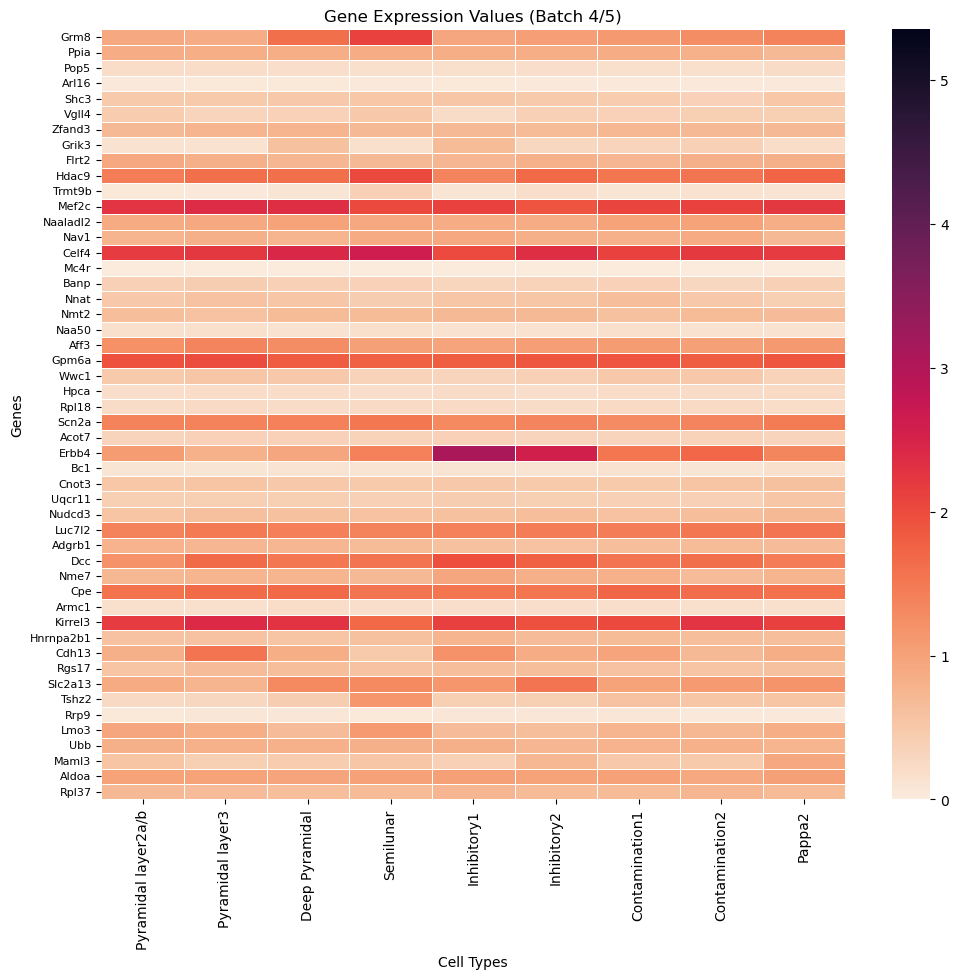

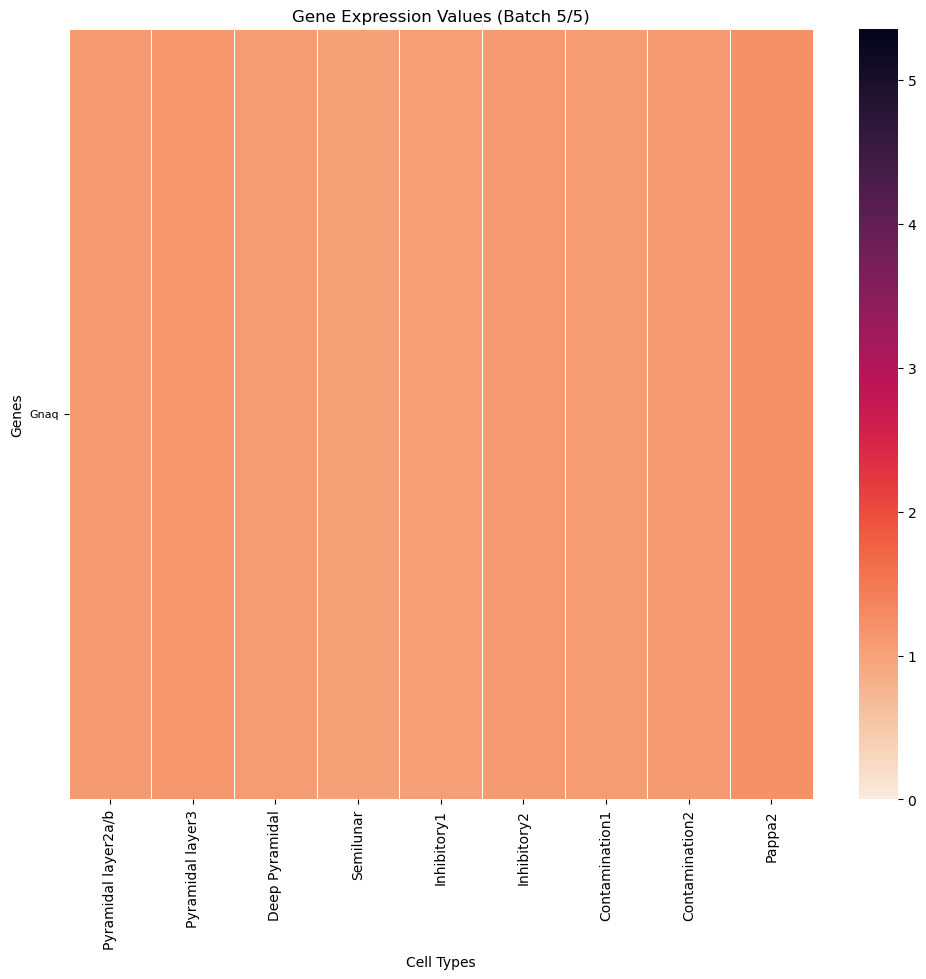

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# batch_size = 50  # Number of genes per batch
# num_batches = len(union50) // batch_size + (1 if len(union50) % batch_size != 0 else 0)

# Step 1: Find global min and max expression values across all batches
global_min, global_max = np.inf, -np.inf

for batch_idx in range(num_batches):
    gene_batch = union50[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    raw_data_df = pd.DataFrame(index=gene_batch)

    # Explicitly maintain column order
    columns_order = []

    for i in range(9):

        i = str(i)
        cluster_samples = X_test[X_test.obs['leiden'] == i]
        cluster_values = []

        for gene in gene_batch:
            gene_index = None
            if gene in cluster_samples.var.index:
                gene_index = cluster_samples.var.index.get_loc(gene)
            
            if gene_index is None:
                cluster_values.append(0)
                continue

            gene_expression_values = cluster_samples.raw[:, gene_index].X
            mean_expression = np.mean(gene_expression_values)
            
            cluster_values.append(mean_expression)

        # Maintain column order by appending each cluster's name to the list
        column_name = cluster_decode[int(i)]
        raw_data_df[column_name] = cluster_values
        columns_order.append(column_name)  # Track the column order

    # Reorder the DataFrame columns to preserve the order in which they were added
    raw_data_df = raw_data_df[columns_order]
    
    # Update global min and max
    global_min = min(global_min, raw_data_df.min().min())
    global_max = max(global_max, raw_data_df.max().max())

# Step 2: Plot heatmaps with shared scale
for batch_idx in range(num_batches):
    gene_batch = union50[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    raw_data_df = pd.DataFrame(index=gene_batch)

    # Explicitly maintain column order
    columns_order = []

    for i in range(9):
        i = str(i)
        cluster_samples = X_test[X_test.obs['leiden'] == i]
        cluster_values = []

        for gene in gene_batch:
            gene_index = None
            if gene in cluster_samples.var.index:
                gene_index = cluster_samples.var.index.get_loc(gene)
            
            if gene_index is None:
                cluster_values.append(0)
                continue

            gene_expression_values = cluster_samples.raw[:, gene_index].X
            mean_expression = np.mean(gene_expression_values)
            
            cluster_values.append(mean_expression)

        column_name = cluster_decode[int(i)]
        raw_data_df[column_name] = cluster_values
        columns_order.append(column_name)

    # Ensure column order remains consistent
    raw_data_df = raw_data_df[columns_order]

    raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

    # Generate heatmap for the current batch using global min and max
    plt.figure(figsize=(12, 10))
    sns.heatmap(raw_data_df, annot=False, cmap="rocket_r", linewidths=.5, vmin=global_min, vmax=global_max)

    plt.title(f'Gene Expression Values (Batch {batch_idx + 1}/{num_batches})')
    plt.xlabel("Cell Types")
    plt.ylabel("Genes")
    
    plt.yticks(rotation=0, fontsize=8)

    # Show the plot for each batch
    plt.show()



# import seaborn as sns
# import matplotlib.pyplot as plt

# raw_data_df = pd.DataFrame(index=union50 )


# for i in X_test.obs['leiden'].unique():
#     print(f"Leiden cluster: {i}")
#     cluster_samples = X_test[X_test.obs['leiden'] == i]
#     cluster_values = []

#     # print(cluster_samples.var['gene_ids'])

#     for gene in union50:
#         # Find the matching Ensembl ID
#         # print(cluster_samples.var['gene_ids'])
#         # if 'Gm' in gene[0:2] or 'mt-' in gene[0:3] or 'Rik' in gene:
#         #     continue
#         gene_index = None
#         if gene in cluster_samples.var.index:
#             gene_index = cluster_samples.var.index.get_loc(gene)
#         # print(gene_index)
        
#         if gene_index is None:
#             cluster_values.append(0)  # Append 0 if gene not found
#             continue
#         # print(gene_index)
#         # Get raw gene expression data for the selected cluster and gene
#         gene_expression_values = cluster_samples.raw[:, gene_index].X
#         # print(gene_expression_values)
#         # Compute the mean expression value across all samples for this gene
#         mean_expression = np.mean(gene_expression_values)
        
#         cluster_values.append(mean_expression)

#     # Store the averaged values for this cluster
#     raw_data_df[cluster_decode[int(i)]] = cluster_values
    
# # Step 1: Convert all data to numeric
# raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce')

# # Step 2: Handle NaN values
# raw_data_df.fillna(0, inplace=True)

# # Step 3: Convert the DataFrame to float
# raw_data_df = raw_data_df.astype(float)

# # # Create a heatmap using seaborn
# # plt.figure(figsize=(10, 6))
# # sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

# # # Adding labels and title
# # plt.title("Heatmap of Gene Expression")
# # plt.xlabel("Cell Types")
# # plt.ylabel("Genes")

# # # Show the plot
# # plt.show()

# plt.figure(figsize=(12, 10))
# sns.heatmap(raw_data_df, annot=False, cmap="rocket_r", linewidths=.5)

# plt.title(f'Gene Expression Values')
# plt.xlabel("Cell Types")
# plt.ylabel("Genes")

# # Rotate the y-axis labels if needed
# plt.yticks(rotation=0, fontsize=8)  # Adjust fontsize as needed

# plt.show()




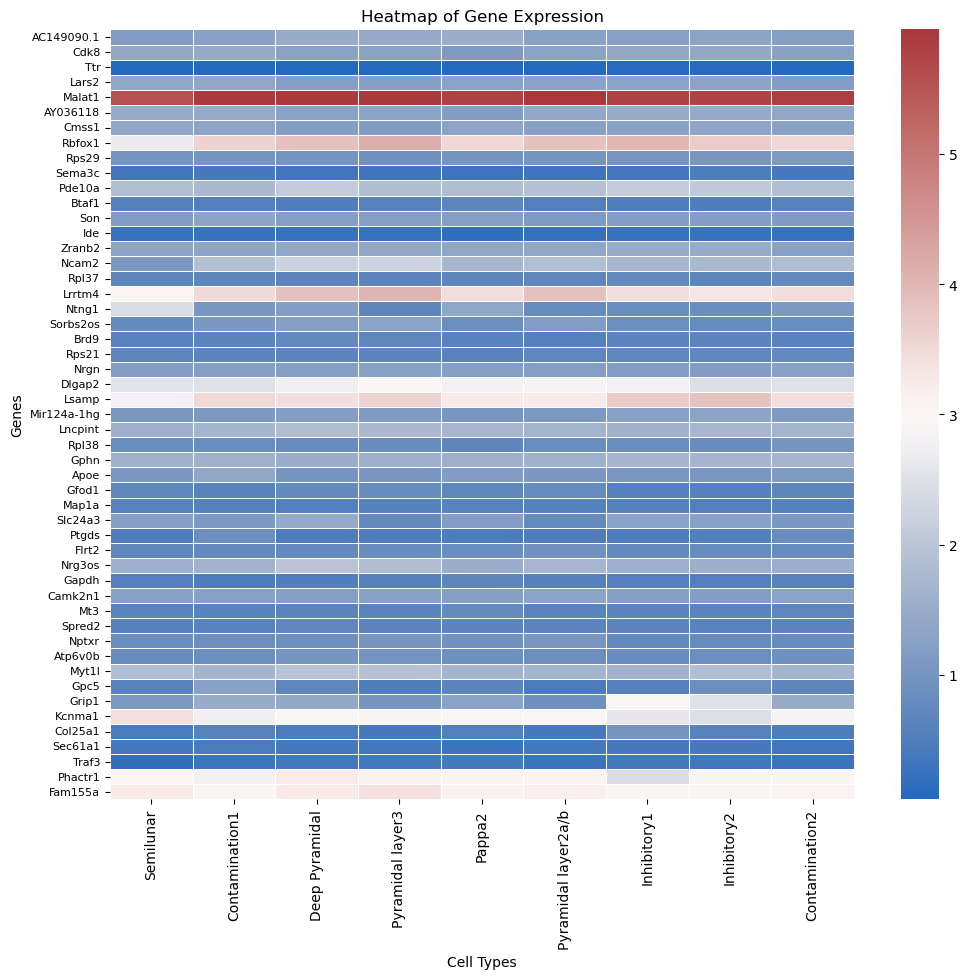

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Convert all data to numeric
raw_data_df = raw_data_df.apply(pd.to_numeric, errors='coerce')

# Step 2: Handle NaN values
raw_data_df.fillna(0, inplace=True)

# Step 3: Convert the DataFrame to float
raw_data_df = raw_data_df.astype(float)

# # Create a heatmap using seaborn
# plt.figure(figsize=(10, 6))
# sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

# # Adding labels and title
# plt.title("Heatmap of Gene Expression")
# plt.xlabel("Cell Types")
# plt.ylabel("Genes")

# # Show the plot
# plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(raw_data_df, annot=False, cmap="vlag", linewidths=.5)

plt.title("Heatmap of Gene Expression")
plt.xlabel("Cell Types")
plt.ylabel("Genes")

# Rotate the y-axis labels if needed
plt.yticks(rotation=0, fontsize=8)  # Adjust fontsize as needed

plt.show()

In [ ]:
for i in raw_data_df:
    for j, gene in enumerate(raw_data_df[i]):

        if abs(gene) > 1: 
            print(f'{i}, {union50[j]}, {gene}')

# GO